In [827]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import gower
import re
import csv
import warnings
import missingno as msno
from math import pi
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from itertools import combinations

In [828]:
#Config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [829]:
def save_fig(title):
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    filename = title.lower().replace(" ", "_").replace("/", "-") + ".png"
    plt.savefig(f"../figures/{filename}", dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

In [830]:
#Data loading
try:
    df_raw = pd.read_csv('../data/raw/mental-heath-in-tech-2016_20161114.csv')
    df_raw.shape
except FileNotFoundError:
    print('Dataset not found.')

(1433, 63)

In [831]:
#Structural Audit
df_raw.head()

"Are you self-employed?"  \
0                             0   
1                             0   
2                             0   
3                             1   
4                             0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                1.0              

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                NaN                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                NaN                                                
1                                                Yes                                                
2                                                NaN                                                
3                                                NaN                                                
4                                                Yes                                                

  Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                 No                                                                                       
1                                                Yes                                                                                       
2                                                 No                                                                                       
3                                                NaN                                                                                       
4                                                 No                                                                                       

  Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                 No                                                            
1                                                Yes                                                            
2                                                 No                                                            
3                                                NaN                                                            
4                                                 No                                               

In [832]:
#Vartypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0       "Are you self-employed?"                                                                                                                                                      1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

In [833]:
#Statistics
df_raw.describe(include='all')

"Are you self-employed?"  \
count                    1433.000000   
unique                           NaN   
top                              NaN   
freq                             NaN   
mean                        0.200279   
std                         0.400349   
min                         0.000000   
25%                         0.000000   
50%                         0.000000   
75%                         0.000000   
max                         1.000000   

       How many employees does your company or organization have?  \
count                                                1146           
unique                                                  6           
top                                                26-100           
freq                                                  292           
mean                                                  NaN           
std                                                   NaN           
min                                                   NaN           
25%                                                   NaN           
50%                                                   NaN           
75%                                                   NaN           
max                                                   NaN           

        Is your employer primarily a tech company/organization?  \
count                                         1146.000000         
unique                                                NaN         
top                                                   NaN         
freq                                                  NaN         
mean                                             0.770506         
std                                              0.420691         
min                                              0.000000         
25%                                              1.000000         
50%                                              1.000000         
75%                                              1.000000         
max                                              1.000000         

        Is your primary role within your company related to tech/IT?  \
count                                          263.000000              
unique                                                NaN              
top                                                   NaN              
freq                                                  NaN              
mean                                             0.942966              
std                                              0.232350              
min                                              0.000000              
25%                                              1.000000              
50%                                              1.000000              
75%                                              1.000000              
max                                              1.000000              

       Does your employer provide mental health benefits as part of healthcare coverage?  \
count                                                1146                                  
unique                                                  4                                  
top                                                   Yes                                  
freq                                                  531                                  
mean                                                  NaN                                  
std                                                   NaN                                  
min                                                   NaN                                  
25%                                                   NaN                                  
50%                                                   NaN                                  
75%                                                   NaN                                  
max                 

In [834]:
#Scope Reduction
df_scoped = df_raw[df_raw['    "Are you self-employed?"'] == 0].copy()

tech_filter = (
    (df_scoped['Is your employer primarily a tech company/organization?'] == 1) | 
    (df_scoped['Is your primary role within your company related to tech/IT?'] == 1)
)
df_scoped = df_scoped[tech_filter]

cols_to_drop = [
    '    "Are you self-employed?"',
    'What country do you live in?',
    'What US state or territory do you live in?',
    'What US state or territory do you work in?',
    'Why or why not?',
    'Why or why not?.1'
]

df_scoped = df_scoped.drop(columns=cols_to_drop, errors='ignore')

print(f'Final shape: {df_scoped.shape}')

Final shape: (1131, 57)


In [835]:
#Standardize Column Names
df_scoped.columns.tolist()

['How many employees does your company or organization have?',
 'Is your employer primarily a tech company/organization?',
 'Is your primary role within your company related to tech/IT?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'Do you know the options for mental health care available under your employer-provided coverage?',
 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
 'Do 

In [836]:
#Column snake case map
new_cols = {
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'is_tech_company',
    'Is your primary role within your company related to tech/IT?': 'is_tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'benefits_coverage',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'offer_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequence_employer',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequence_physical',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'discuss_supervisor',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'mh_vs_ph',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'obs_consequence_coworkers',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?': 'medical_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'impacted_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'impacted_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'productivity_affected',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'percent_work_time_affected',
    'Do you have previous employers?': 'has_prev_employer',
    'Have your previous employers provided mental health benefits?': 'prev_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'prev_know_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequence',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequence_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_discuss_supervisor',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_mh_vs_ph',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_obs_consequence',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'interview_physical_reveal',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'interview_mh_reveal',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'impact_on_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworker_stigma',
    'How willing would you be to share with friends and family that you have a mental illness?': 'share_with_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'bad_response_observed',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'influence_reveal',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'curr_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'conditions_curr',
    'If maybe, what condition(s) do you believe you have?': 'conditions_suspected',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'diagnosed_prof',
    'If so, what condition(s) were you diagnosed with?': 'conditions_prof_diag',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you work in?': 'country_work',
    'Which of the following best describes your work position?': 'work_position',
    'Do you work remotely?': 'remote'
}

In [837]:
#Rename columns
df_clean = df_scoped.rename(columns=new_cols).copy()
df_clean.columns.tolist()

['company_size',
 'is_tech_company',
 'is_tech_role',
 'benefits_coverage',
 'know_options',
 'discussed_mh',
 'offer_resources',
 'anonymity_protected',
 'leave_difficulty',
 'neg_consequence_employer',
 'neg_consequence_physical',
 'discuss_coworkers',
 'discuss_supervisor',
 'mh_vs_ph',
 'obs_consequence_coworkers',
 'medical_coverage',
 'know_local_resources',
 'reveal_clients',
 'impacted_clients',
 'reveal_coworkers',
 'impacted_coworkers',
 'productivity_affected',
 'percent_work_time_affected',
 'has_prev_employer',
 'prev_benefits',
 'prev_know_options',
 'prev_discussed_mh',
 'prev_resources',
 'prev_anonymity',
 'prev_neg_consequence',
 'prev_neg_consequence_physical',
 'prev_discuss_coworkers',
 'prev_discuss_supervisor',
 'prev_mh_vs_ph',
 'prev_obs_consequence',
 'interview_physical_reveal',
 'interview_mh_reveal',
 'impact_on_career',
 'coworker_stigma',
 'share_with_friends_family',
 'bad_response_observed',
 'influence_reveal',
 'family_history',
 'past_mh_disorder',
 

In [838]:
#Clean Gender
df_clean['gender'].value_counts(dropna=False)

gender
Male                                                       501
male                                                       194
Female                                                     118
female                                                      76
M                                                           69
m                                                           55
F                                                           23
f                                                           20
Female                                                       6
Male                                                         5
non-binary                                                   4
woman                                                        4
NaN                                                          3
male                                                         2
Male (cis)                                                   2
man                                             

In [839]:
#Normalize
df_clean['gender'] = df_clean['gender'].astype(str).str.lower().str.strip().replace('nan', np.nan)

def map_gender(text):
    if pd.isna(text):
        return 'Other'
    if re.search(r'non.?binary|genderqueer|genderfluid|agender|bigender|enby|queer|androgynous|multi.?gender|flux|transfeminine|human|nb |femme|9:1|bodied', text):
        return 'Other'
    if re.search(r'\bm(?:ale)?\b|\bm\b|man|cis.*male|dude|cisdude|cis.*man|ftm|sex.*male|mail', text):
        return 'Male'
    if re.search(r'\bf(?:emale)?\b|\bf\b|woman|cis.*femal|m2f|fem|fm|transitioned|transgender.*woman', text):
        return 'Female'
    return 'Other'

df_clean['gender'] = df_clean['gender'].apply(map_gender)

# Check the result
df_clean['gender'].value_counts()

gender
Male      851
Female    251
Other      29
Name: count, dtype: int64

In [840]:
#Clean Country
freq = df_clean['country_work'].value_counts(normalize=True)
threshold = 0.01
mask = freq[freq < threshold].index
df_clean['country_work'] = df_clean['country_work'].replace(mask, 'Other')
df_clean['country_work'].value_counts()

country_work
United States of America    702
United Kingdom              133
Other                       120
Canada                       61
Germany                      43
Netherlands                  31
Australia                    26
Sweden                       15
Name: count, dtype: int64

In [841]:
#Clean Age
df_clean['age'] = df_clean['age'].clip(lower=18, upper=75)
df_clean['age'].astype(int)
df_clean['age'].describe()

count    1131.000000
mean       33.381079
std         7.768826
min        18.000000
25%        28.000000
50%        32.000000
75%        38.000000
max        75.000000
Name: age, dtype: float64

In [842]:
#Standardize Binary for dtype interpretation
binary = [col for col in df_clean.columns if df_clean[col].dropna().isin([0, 1]).all() and df_clean[col].nunique(dropna=False) <= 3]
for col in binary:
    df_clean[col] = df_clean[col].map({0: 'No', 1: 'Yes'}).astype('category')

In [843]:
#Explicit typecasting
categorical = df_clean.select_dtypes(include='object').columns
for col in categorical:
    df_clean[col] = df_clean[col].astype('category')

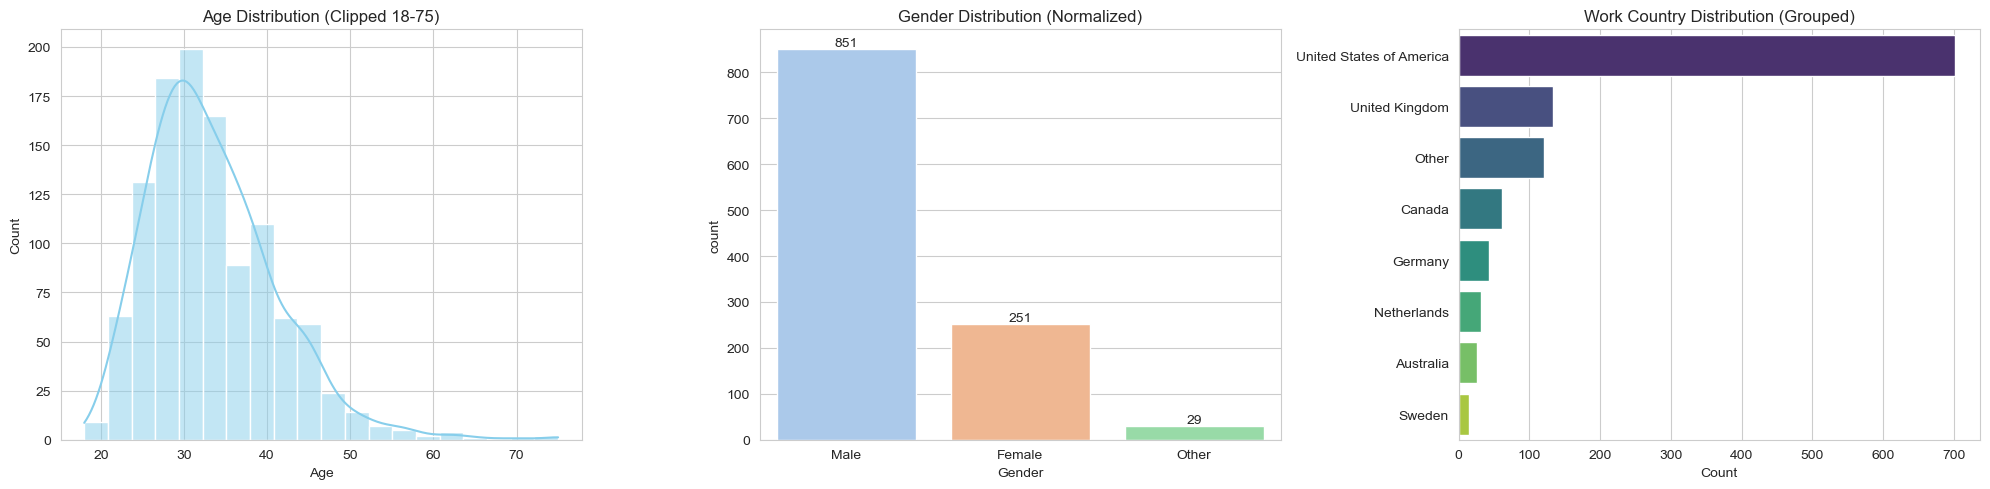

In [844]:
#Demographic EDA
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#Age Distribution
sns.histplot(df_clean['age'], bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Age Distribution (Clipped 18-75)')
axes[0].set_xlabel('Age')

#Gender Distribution
sns.countplot(x='gender', data=df_clean, palette='pastel', order=['Male', 'Female', 'Other'], ax=axes[1])
axes[1].set_title('Gender Distribution (Normalized)')
axes[1].set_xlabel('Gender')
for container in axes[1].containers:
    axes[1].bar_label(container)

#Country Distribution
country_order = df_clean['country_work'].value_counts().index
sns.countplot(y='country_work', data=df_clean, palette='viridis', order=country_order, ax=axes[2])
axes[2].set_title('Work Country Distribution (Grouped)')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

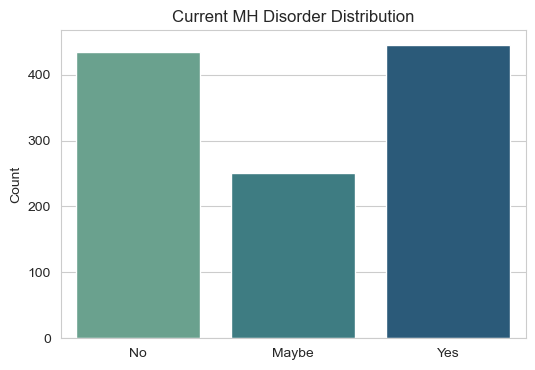

In [845]:
#Proxy Target Variable: Current Mental Health Disorder
plt.figure(figsize=(6, 4))
sns.countplot(x='curr_mh_disorder', data=df_clean, palette='crest', order=['No', 'Maybe', 'Yes'])
plt.title('Current MH Disorder Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

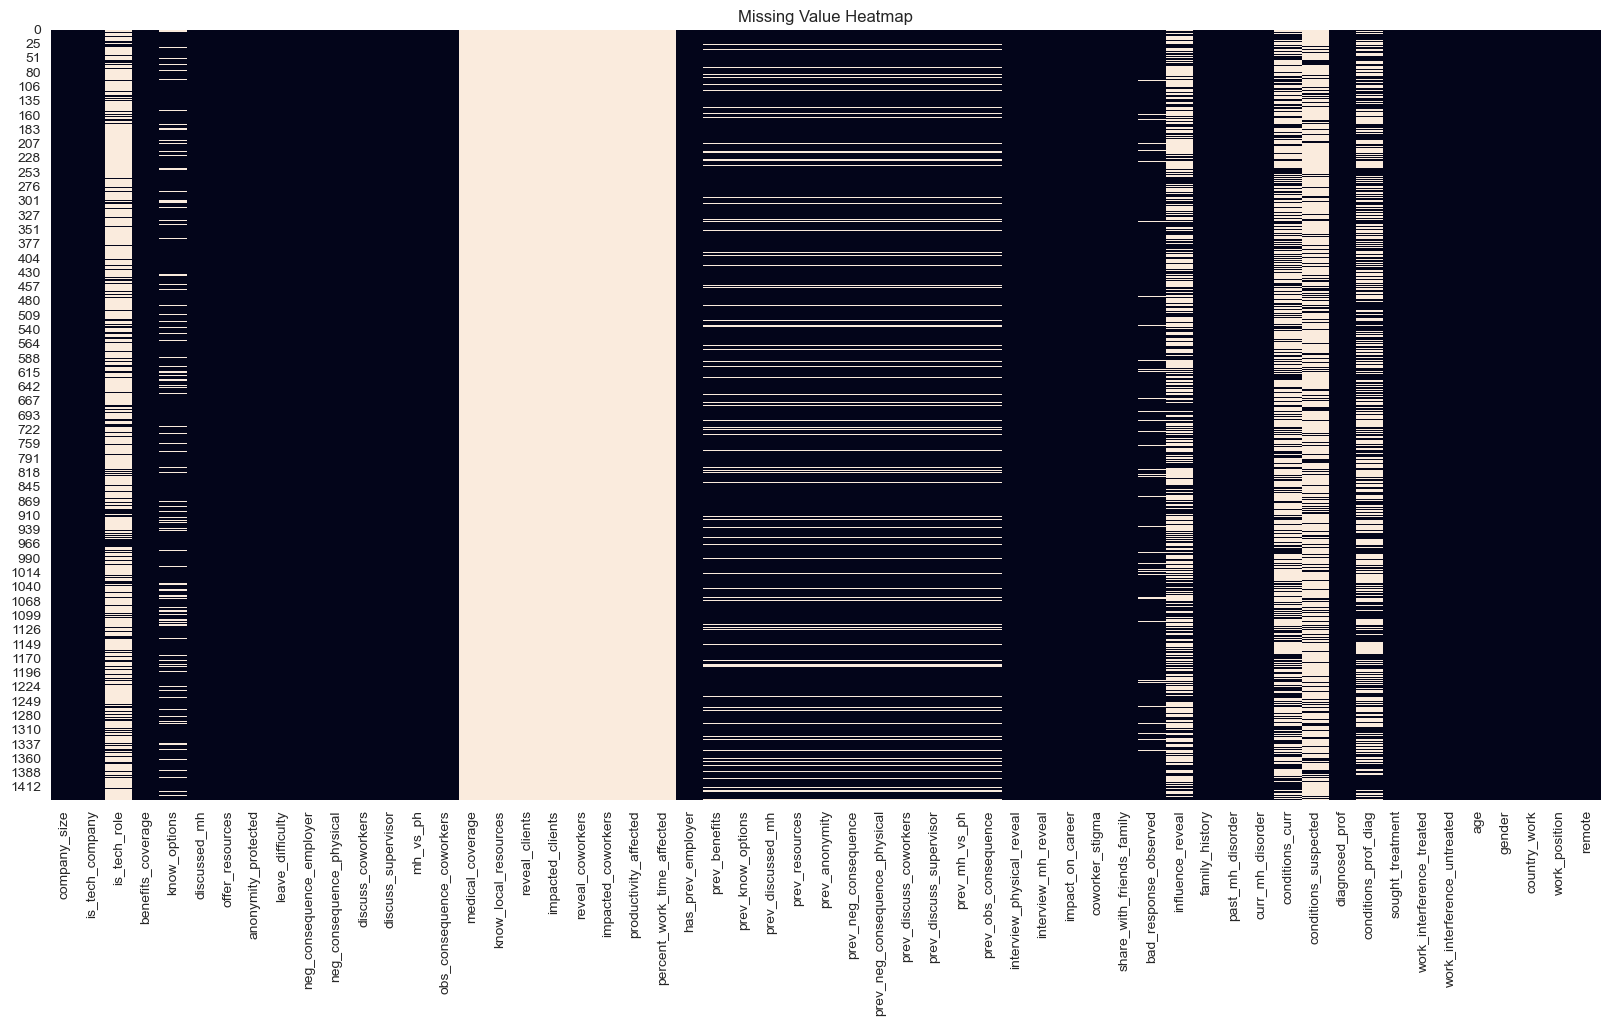

In [846]:
#Missing Value Overview
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

In [847]:
#Missing Value Percentages
df_clean.isna().mean().sort_values(ascending=False)

reveal_coworkers                 1.000000
medical_coverage                 1.000000
percent_work_time_affected       1.000000
productivity_affected            1.000000
impacted_coworkers               1.000000
impacted_clients                 1.000000
reveal_clients                   1.000000
know_local_resources             1.000000
conditions_suspected             0.781609
is_tech_role                     0.780725
conditions_curr                  0.611848
influence_reveal                 0.556145
conditions_prof_diag             0.507515
know_options                     0.117595
prev_discussed_mh                0.113174
prev_resources                   0.113174
prev_benefits                    0.113174
prev_neg_consequence             0.113174
prev_neg_consequence_physical    0.113174
prev_discuss_coworkers           0.113174
prev_discuss_supervisor          0.113174
prev_mh_vs_ph                    0.113174
prev_obs_consequence             0.113174
prev_know_options                0

In [848]:
#Drop fully missing columns
df_clean.dropna(axis=1, how='all', inplace=True)
df_clean.shape

(1131, 49)

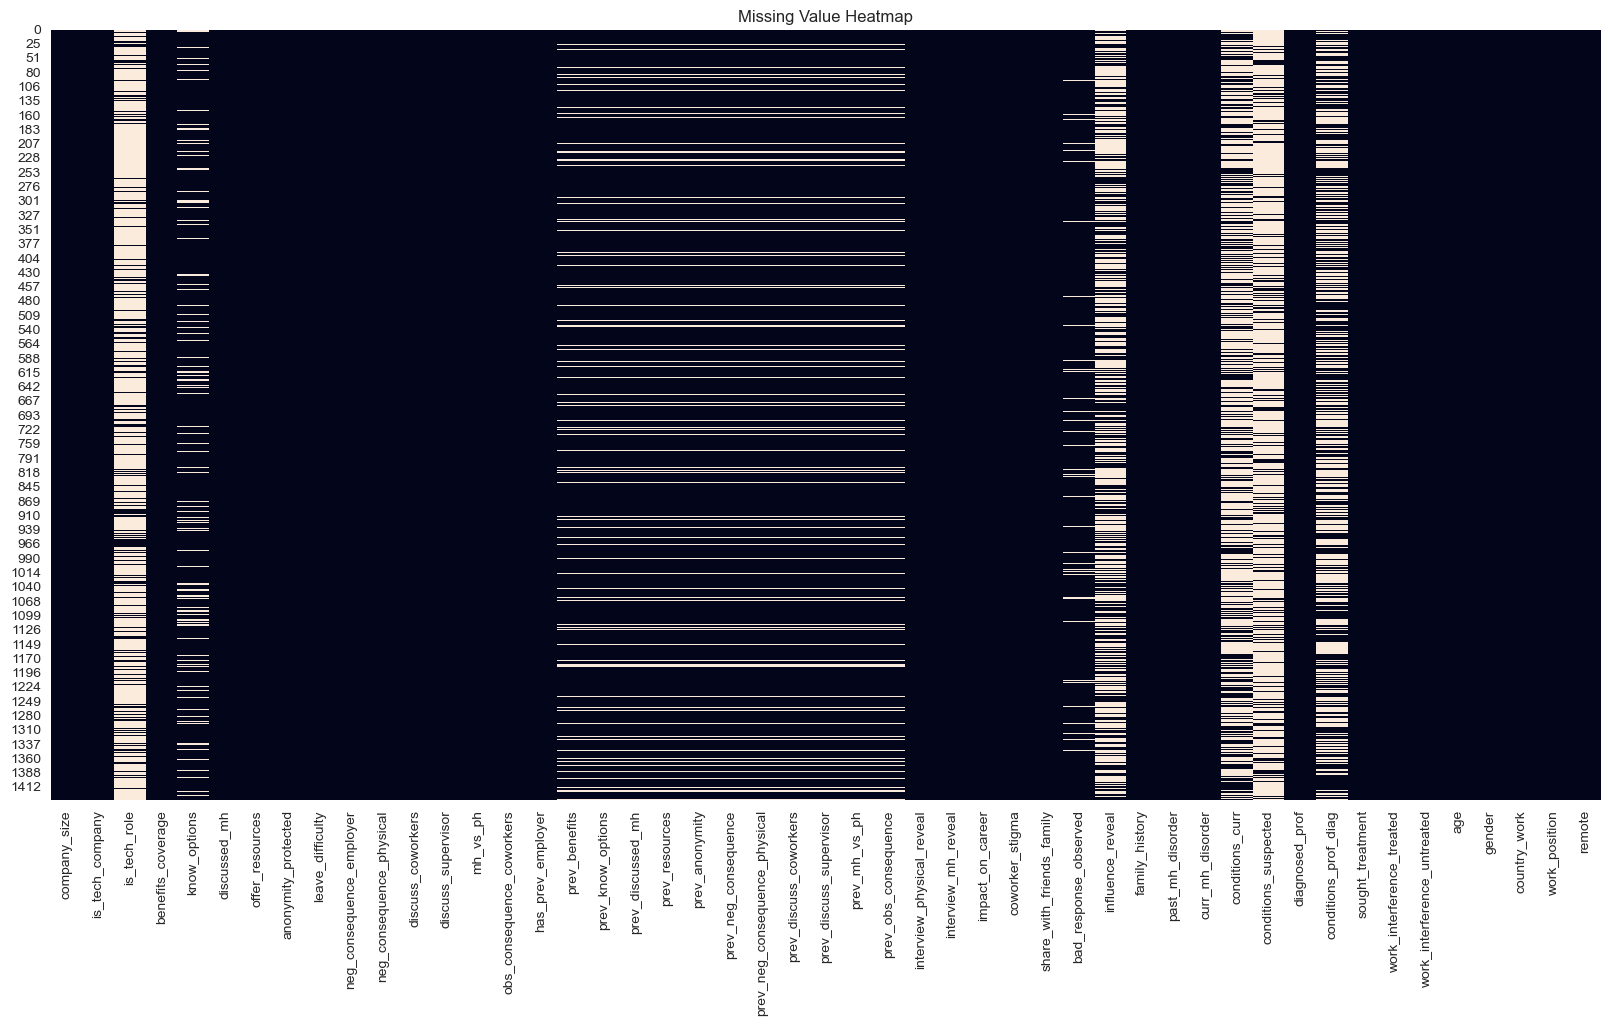

In [849]:
#Missing Value Overview
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

<Figure size 2000x1000 with 0 Axes>

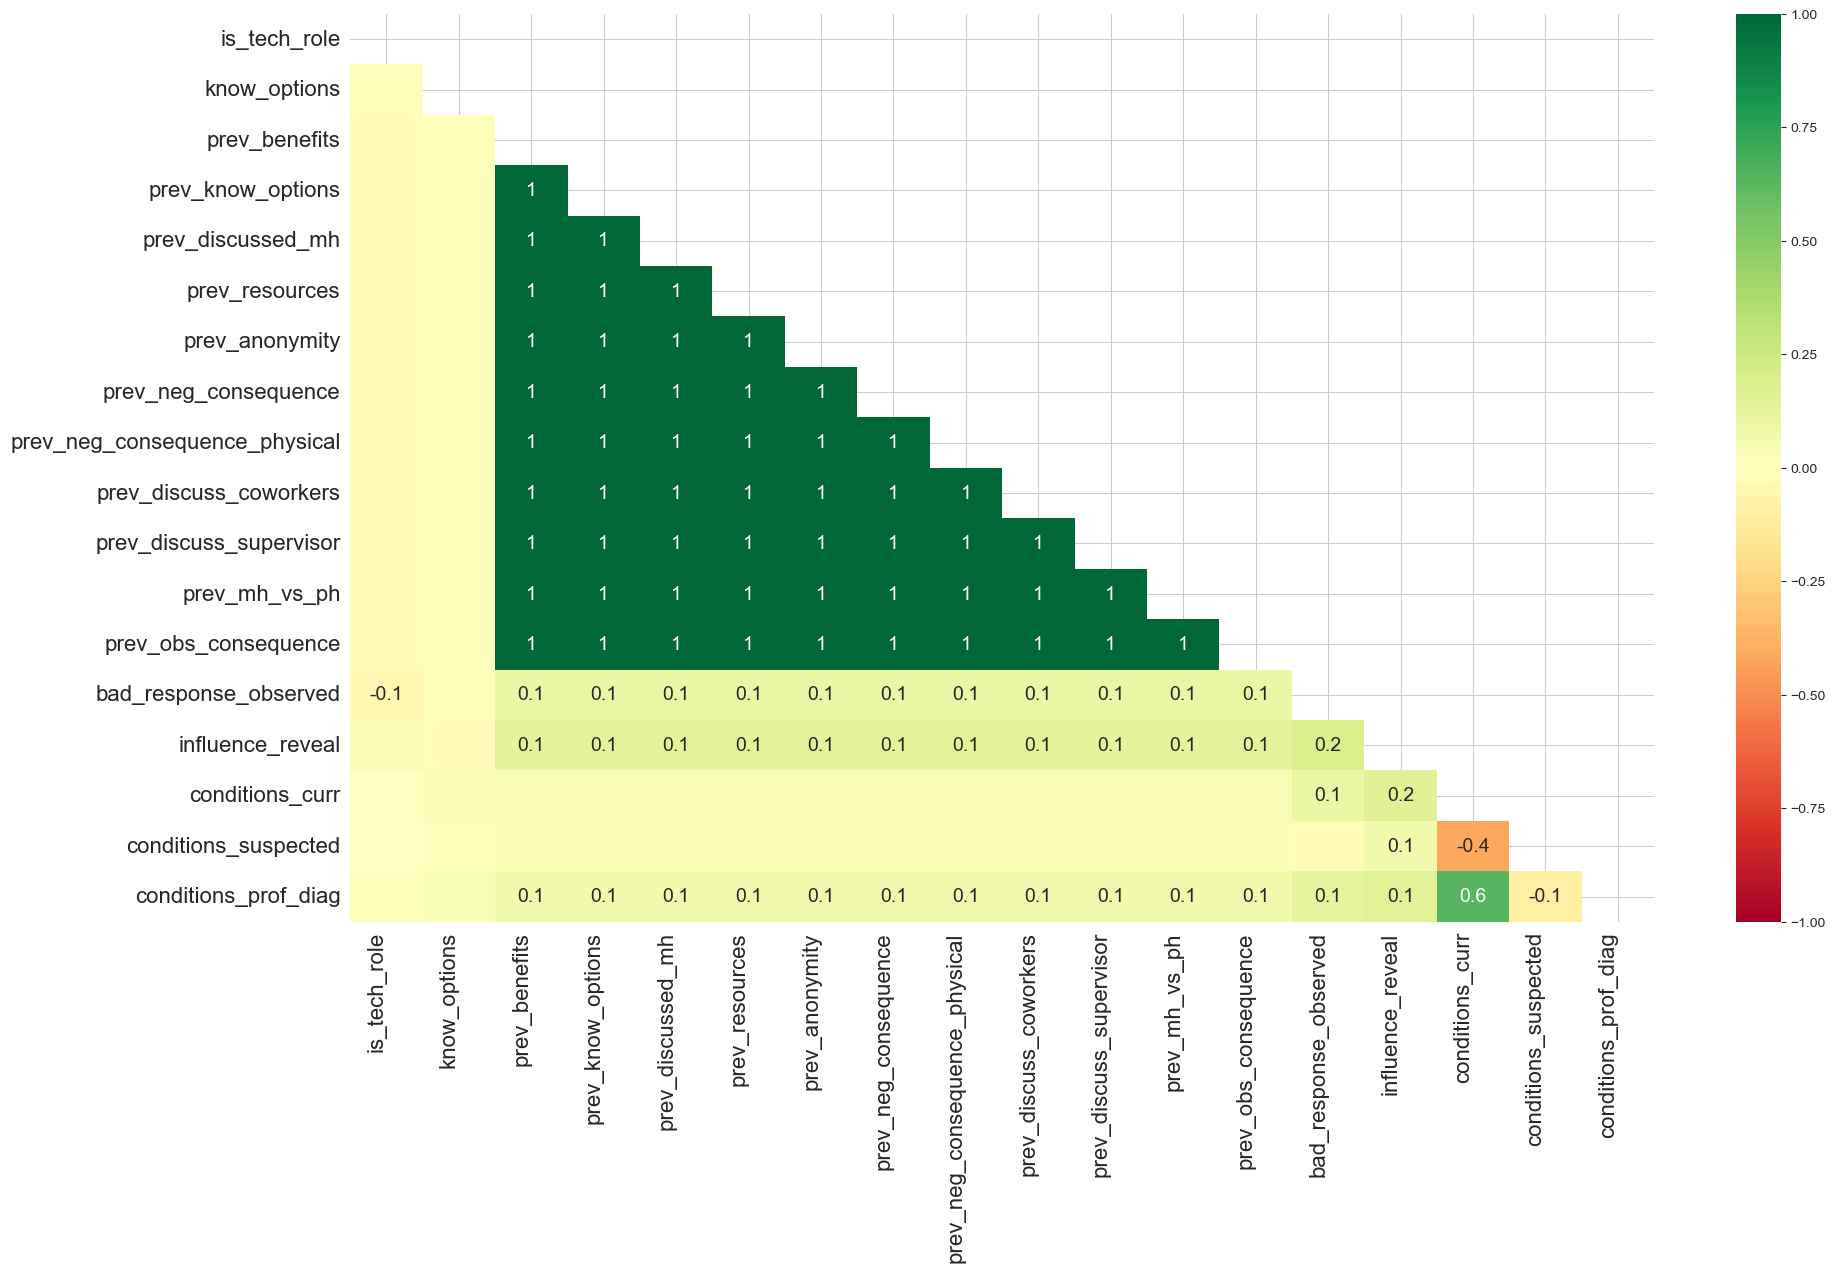

In [850]:
#Nullity correlation heatmap
plt.figure(figsize=(20, 10))
msno.heatmap(df_clean, cmap='RdYlGn')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

<Axes: >

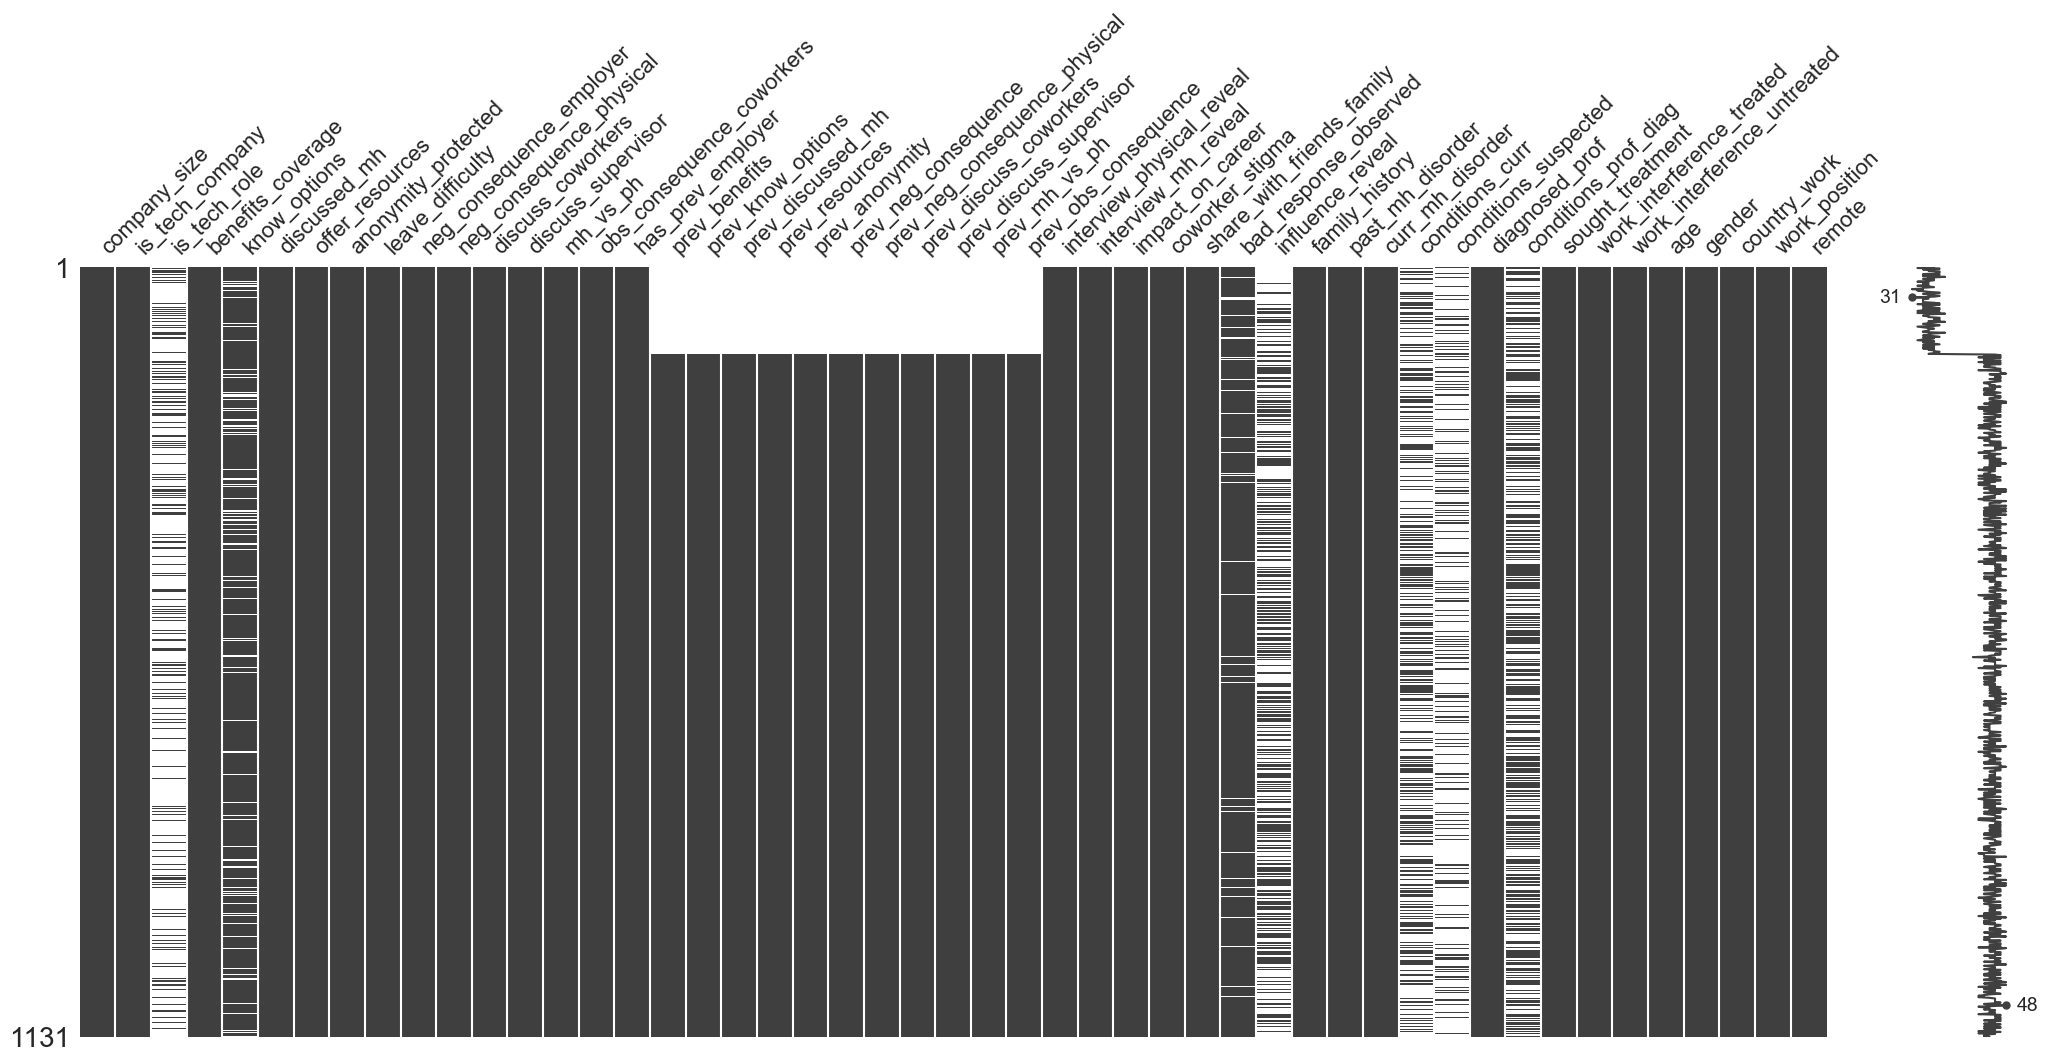

In [851]:
msno.matrix(df_clean.sort_values('has_prev_employer'))

<Axes: >

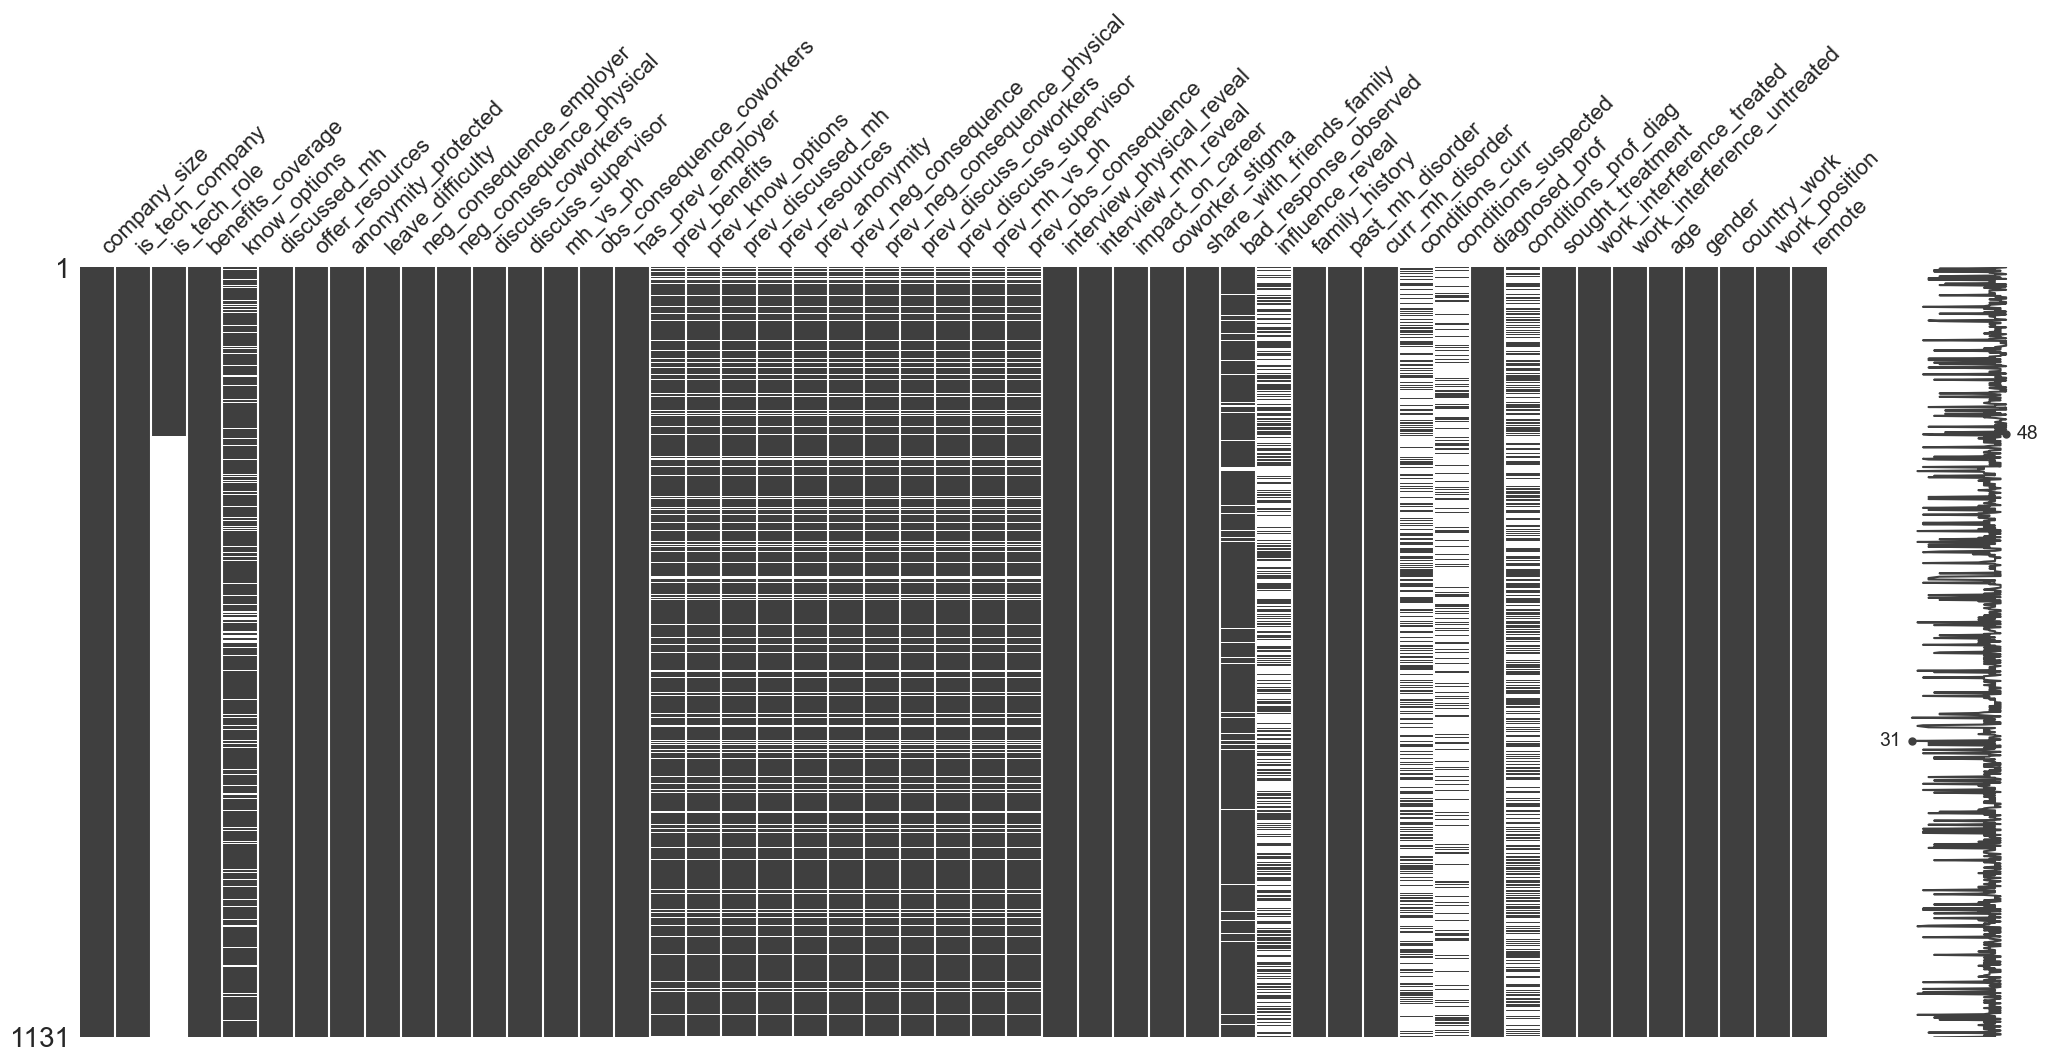

In [852]:
msno.matrix(df_clean.sort_values('is_tech_company'))

In [853]:
print(df_clean.groupby('is_tech_company')['is_tech_role'].apply(lambda x: x.isnull().mean()))

is_tech_company
No     0.0
Yes    1.0
Name: is_tech_role, dtype: float64


<Axes: >

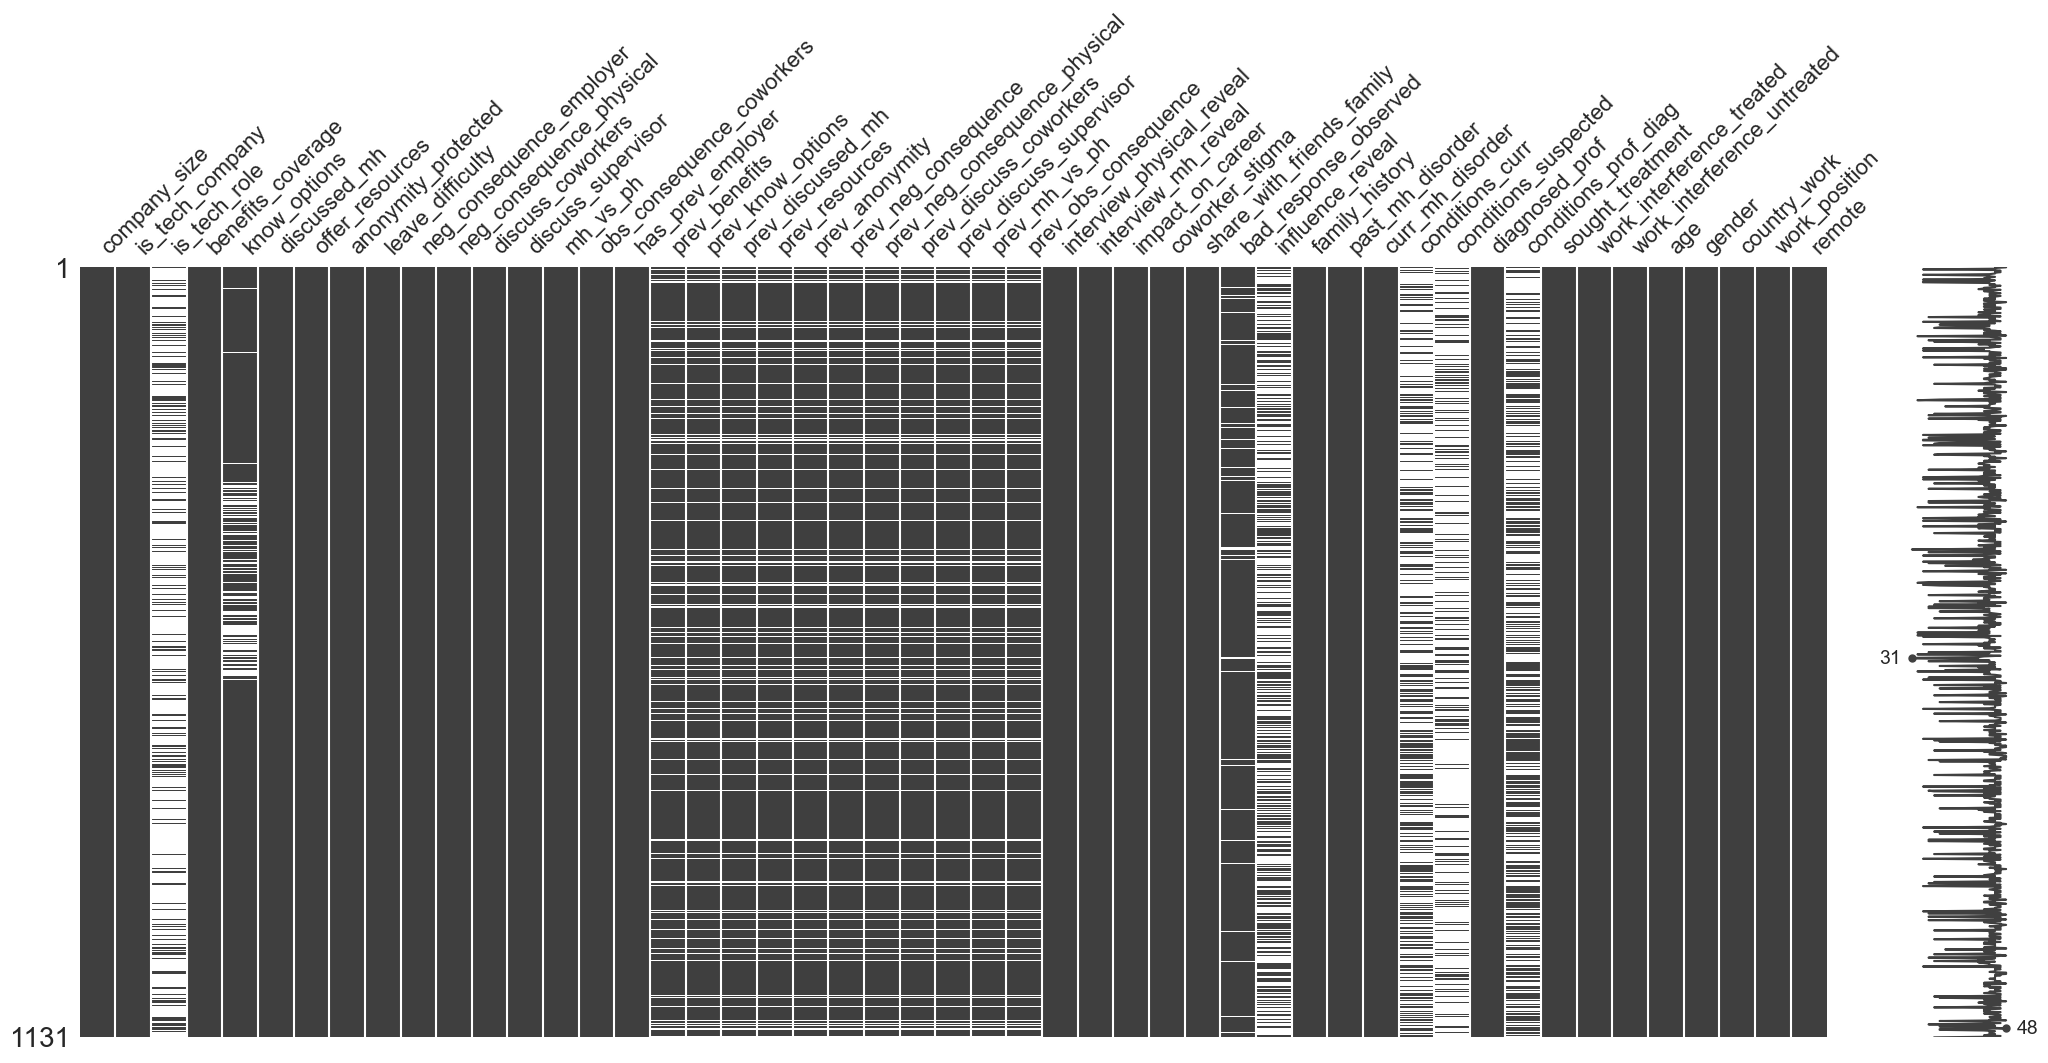

In [854]:
msno.matrix(df_clean.sort_values('benefits_coverage'))

In [855]:
print(df_clean.groupby('benefits_coverage')['know_options'].apply(lambda x: x.isnull().mean()))

benefits_coverage
I don't know                       0.018987
No                                 0.342857
Not eligible for coverage / N/A    0.679012
Yes                                0.000000
Name: know_options, dtype: float64


<Axes: >

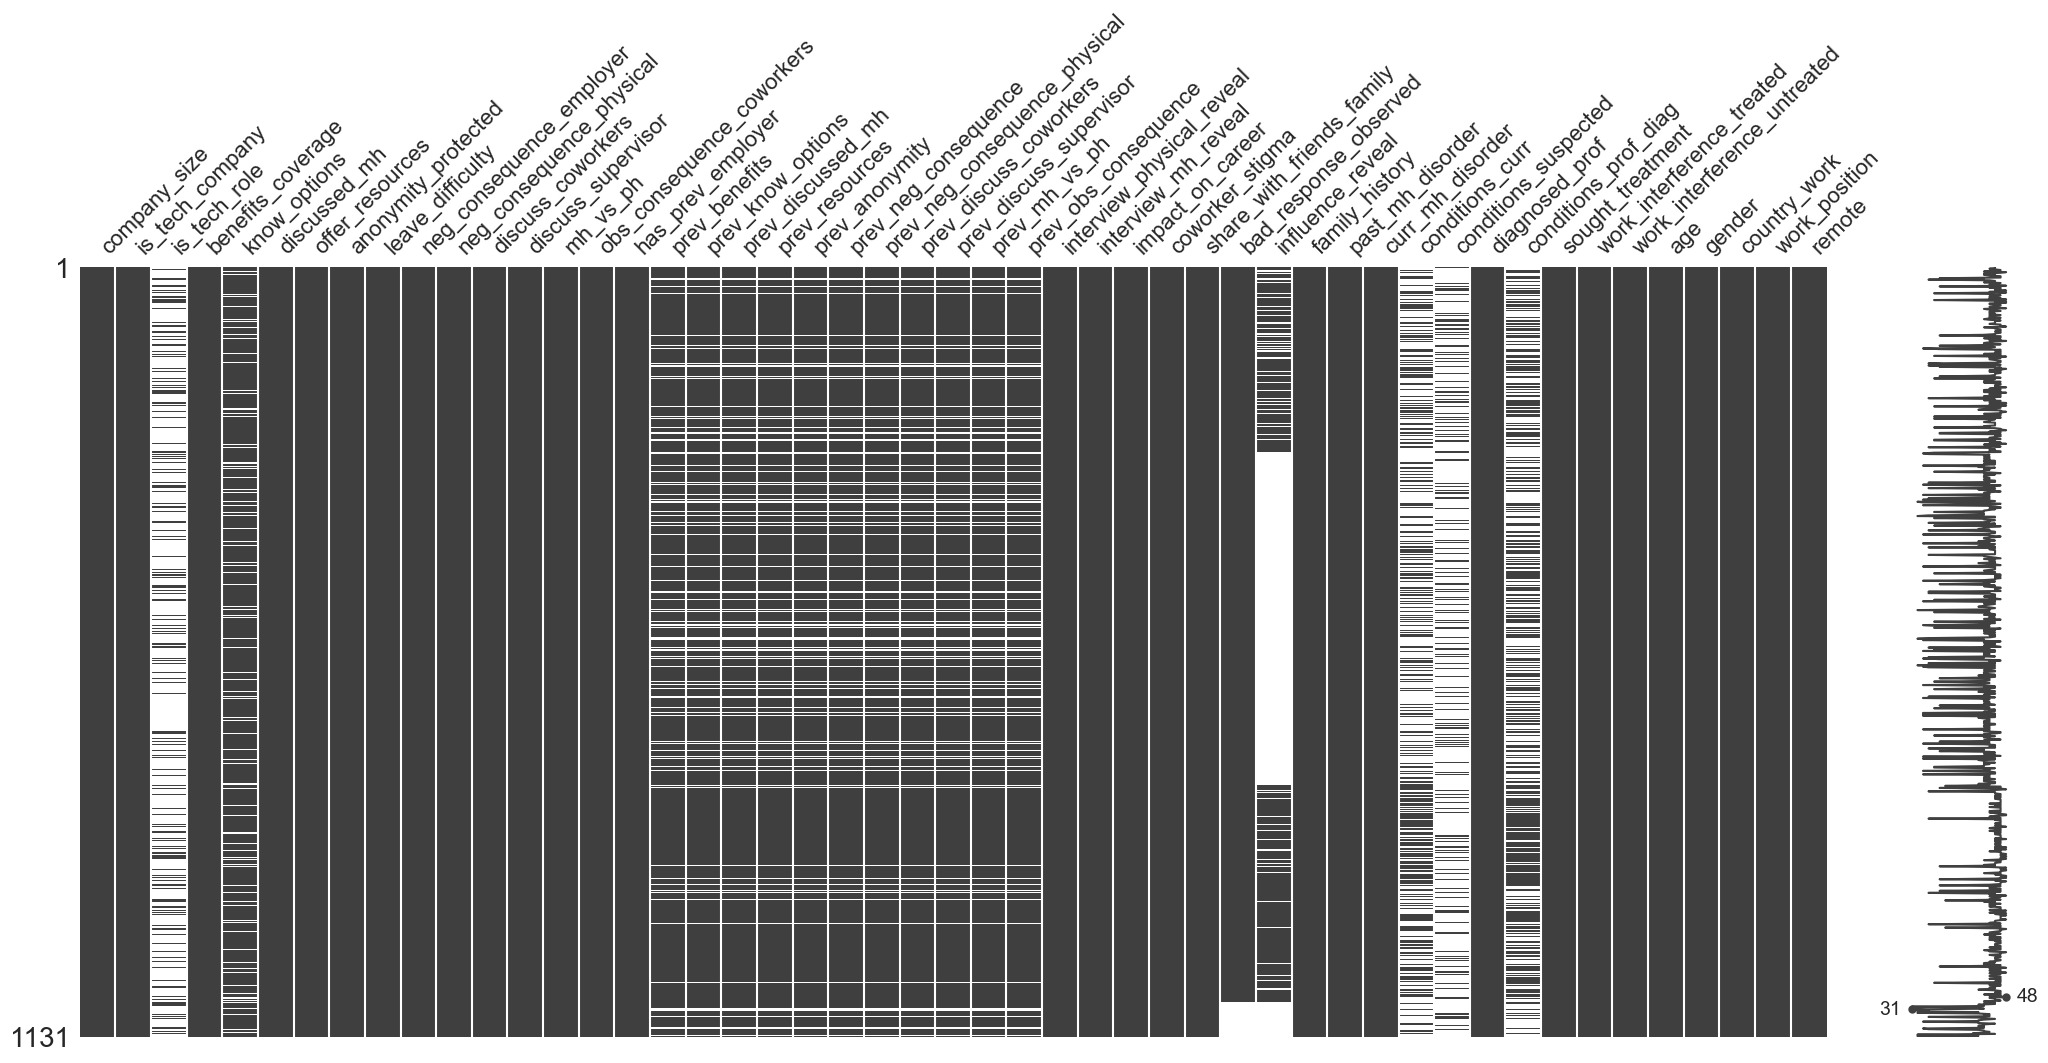

In [856]:
msno.matrix(df_clean.sort_values('bad_response_observed'))

In [857]:
print(df_clean.groupby('bad_response_observed')['influence_reveal'].apply(lambda x: x.isnull().mean()))

bad_response_observed
Maybe/Not sure        0.205882
No                    1.000000
Yes, I experienced    0.171875
Yes, I observed       0.062500
Name: influence_reveal, dtype: float64


<Axes: >

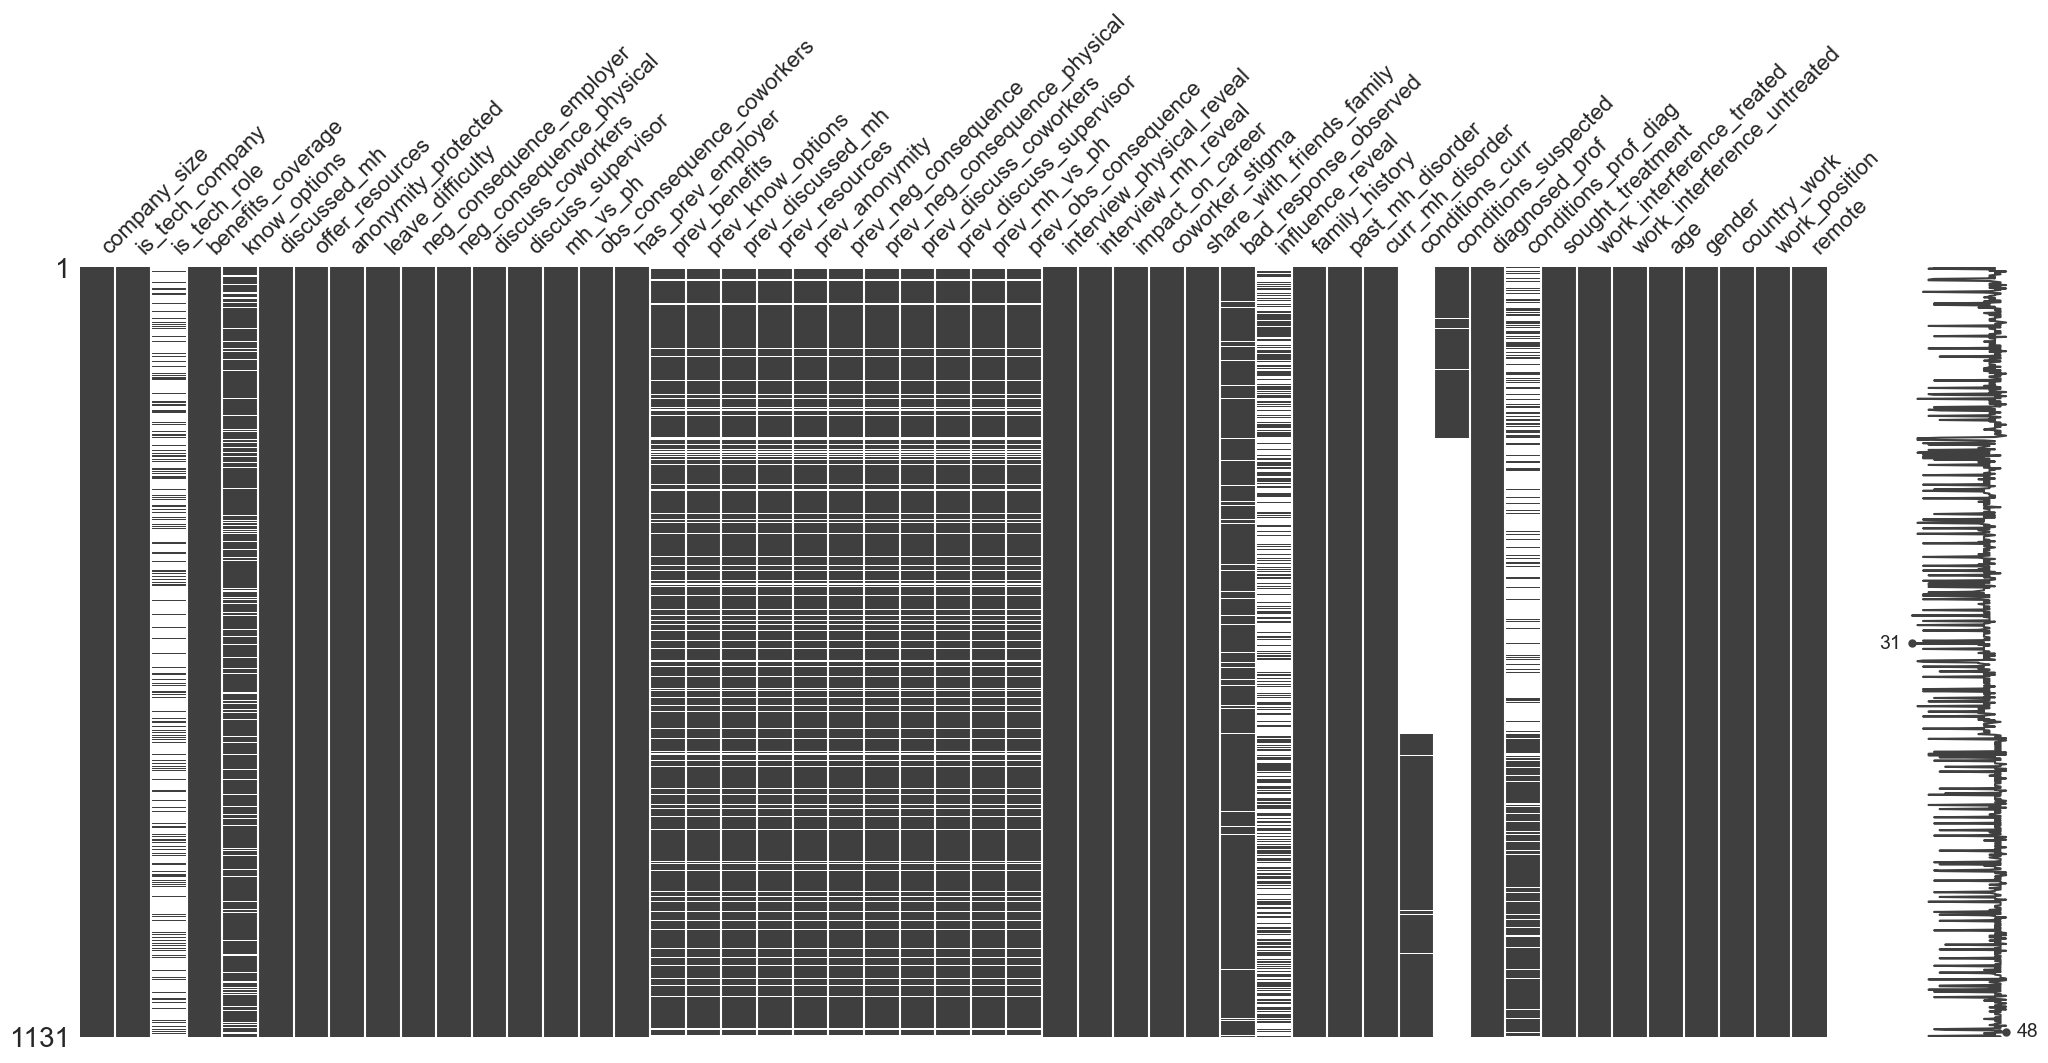

In [858]:
msno.matrix(df_clean.sort_values('curr_mh_disorder'))

In [859]:
print(df_clean.groupby('curr_mh_disorder')['conditions_curr'].apply(lambda x: x.isnull().mean()))

curr_mh_disorder
Maybe    1.000000
No       1.000000
Yes      0.013483
Name: conditions_curr, dtype: float64


In [860]:
print(df_clean.groupby('curr_mh_disorder')['conditions_suspected'].apply(lambda x: x.isnull().mean()))

curr_mh_disorder
Maybe    0.015936
No       1.000000
Yes      1.000000
Name: conditions_suspected, dtype: float64


<Axes: >

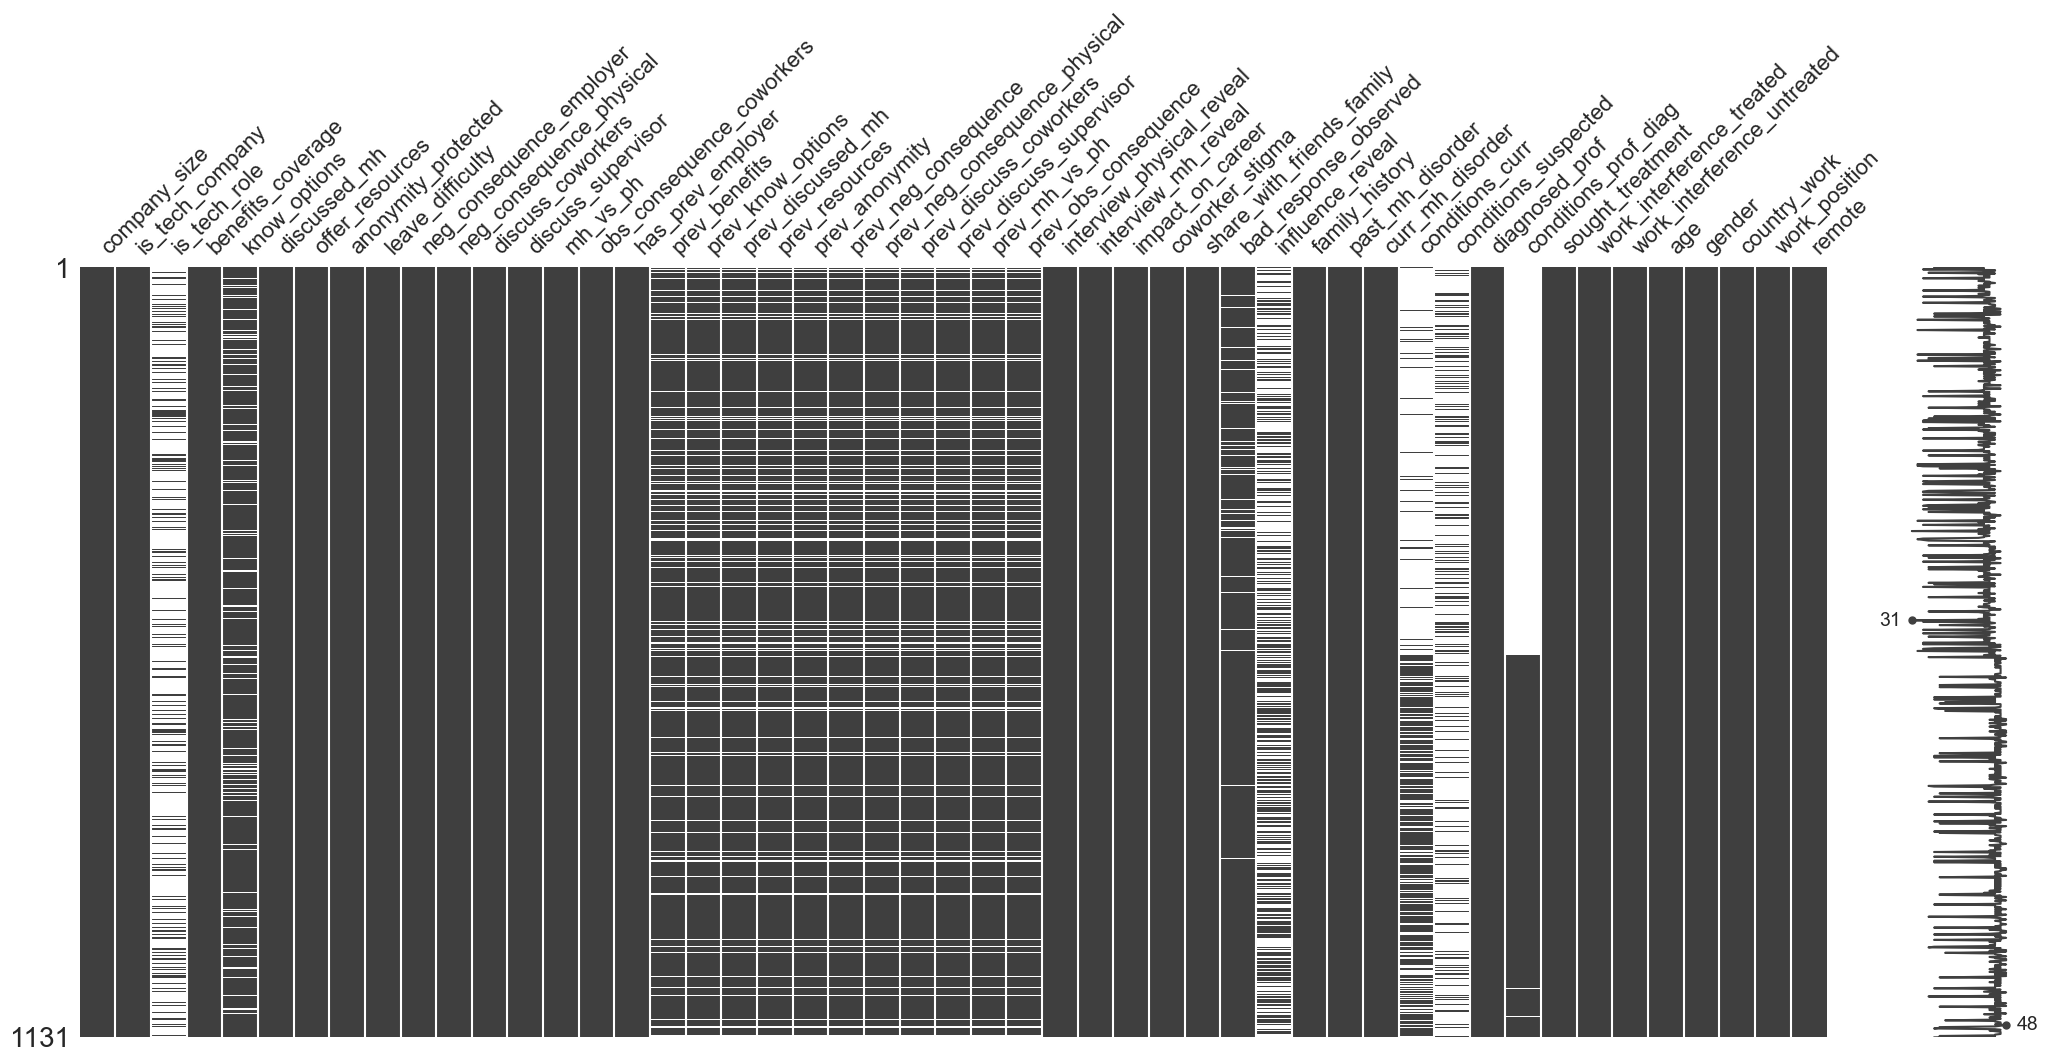

In [861]:
msno.matrix(df_clean.sort_values('diagnosed_prof'))

In [862]:
print(df_clean.groupby('diagnosed_prof')['conditions_prof_diag'].apply(lambda x: x.isnull().mean()))

diagnosed_prof
No     1.00000
Yes    0.00713
Name: conditions_prof_diag, dtype: float64


In [863]:
df_clean.to_csv('../data/processed/df_struct.csv', index=False)

In [864]:
#Structural Imputation

def impute_struct(df, trigger_col, target_cols, trigger_vals_for_skip, fill_val='N/A'):

    if not isinstance(trigger_vals_for_skip, list):
        trigger_vals_for_skip = [trigger_vals_for_skip]
        
    mask_skip = df[trigger_col].isin(trigger_vals_for_skip)
    
    for target in target_cols:
        if target in df.columns:
            if df[target].dtype.name == 'category' and fill_val not in df[target].cat.categories:
                df[target] = df[target].cat.add_categories(fill_val)
            df.loc[mask_skip, target] = df.loc[mask_skip, target].fillna(fill_val)
 
    return df

In [865]:
#Prev employers block
prev_targets = [col for col in df_clean.columns if 'prev_' in col and col != 'has_prev_employer']
df_clean = impute_struct(df_clean, 'has_prev_employer', prev_targets, ['No'])

In [866]:
df_clean = impute_struct(df_clean, 'curr_mh_disorder', ['conditions_curr'], ['No', 'Maybe'])
df_clean = impute_struct(df_clean, 'curr_mh_disorder', ['conditions_suspected'], ['No', 'Yes'])
df_clean = impute_struct(df_clean, 'diagnosed_prof', ['conditions_prof_diag'], ['No'])

In [867]:
df_clean = impute_struct(df_clean, 'bad_response_observed', ['influence_reveal'], ['No'])

In [868]:
df_clean = impute_struct(df_clean, 'benefits_coverage', ['know_options'], ['No', 'Not eligible for coverage / N/A'])

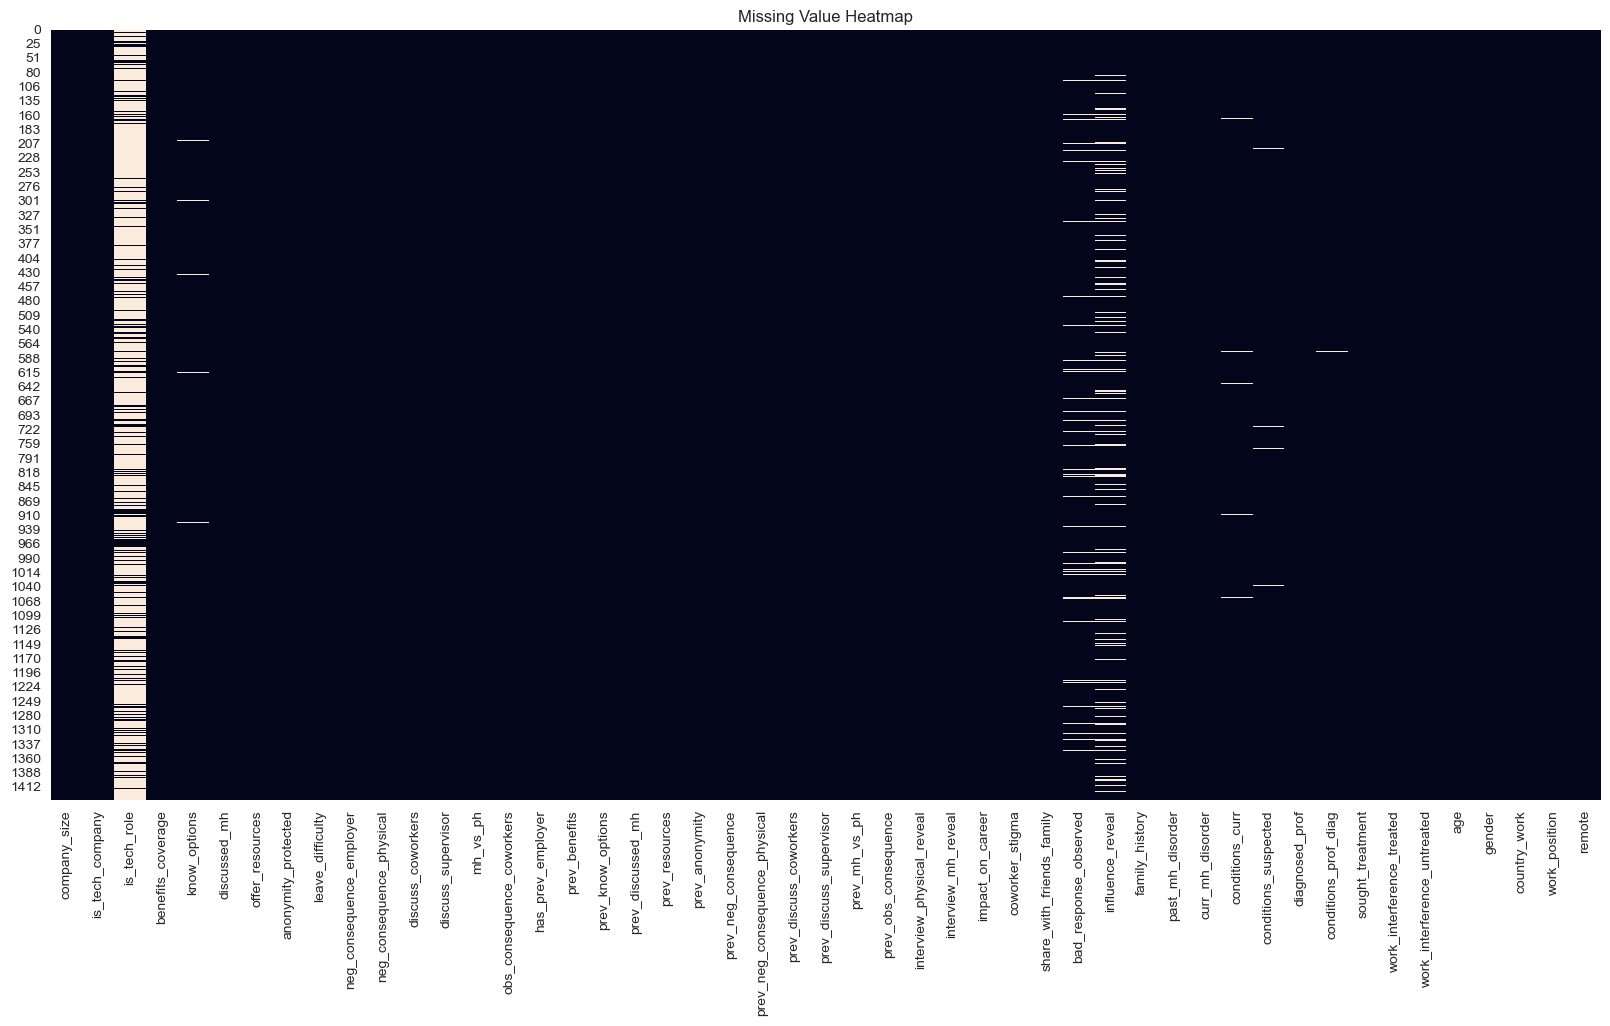

In [869]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

In [870]:
df_clean = df_clean.drop(columns=['is_tech_role'])

In [871]:
#Random Imputation
cols = df_clean.columns[df_clean.isna().any()].tolist()
threshold = 0.01

for col in cols:
    missing = df_clean[col].isna().mean()
    if missing < threshold:
        print(col)
        df_clean = df_clean.dropna(subset=[col])
    else:
        if 'Unknown' not in df_clean[col].cat.categories:
            df_clean[col] = df_clean[col].cat.add_categories('Unknown')
            df_clean[col] = df_clean[col].fillna('Unknown')

know_options
conditions_curr
conditions_suspected
conditions_prof_diag


In [872]:
df_clean.isna().sum().sum()

0

In [873]:
def merge_diagnoses(row):
    conditions = set()
    for c in ['conditions_curr', 'conditions_prof_diag', 'conditions_suspected']:
        val = str(row.get(c, ''))
        # Ignore structural/missing placeholders
        if val not in ['N/A', 'Unknown', 'nan', 'None', '0']:
            # Add valid conditions (split by pipe if pre-merged)
            conditions.update([x.strip() for x in val.split('|') if x.strip()])

    return '|'.join(sorted(conditions)) if conditions else 'N/A'

In [874]:
df_clean['conditions'] = df_clean.apply(merge_diagnoses, axis=1)
cols = ['conditions_curr', 'conditions_suspected', 'conditions_prof_diag']
df_clean = df_clean.drop(columns=cols)

In [875]:
def get_unique_items(df, col):
    unique_items = set()
    # Drop nulls/N/A for inspection
    raw_values = df[df[col] != 'N/A'][col].dropna()

    for row in raw_values:
        # Split by separator (assuming previous step used '|')
        # Note: work_position in raw data often uses no separator or '|',
        # but the standard 2016 data usually comes pre-split or distinct.
        # We'll assume the raw strings might need splitting.
        items = str(row).split('|')
        for item in items:
            unique_items.add(item.strip())

    return sorted(list(unique_items))

print("--- Unique Work Positions ---")
# The raw 'work_position' usually isn't separated by '|' yet, it's just strings.
# But we treat it as text searching, so just listing unique strings is enough.
print(get_unique_items(df_clean, 'work_position')) # Print first 20

print("\n--- Unique Conditions (Merged) ---")
print(get_unique_items(df_clean, 'conditions'))

--- Unique Work Positions ---
['Back-end Developer', 'Designer', 'Dev Evangelist/Advocate', 'DevOps/SysAdmin', 'Executive Leadership', 'Front-end Developer', 'HR', 'One-person shop', 'Other', 'Sales', 'Supervisor/Team Lead', 'Support']

--- Unique Conditions (Merged) ---
['ADD (w/o Hyperactivity)', 'Addictive Disorder', 'Anxiety Disorder (Generalized, Social, Phobia, etc)', 'Asperger Syndrome', "Asperger's", 'Asperges', 'Attention Deficit Disorder', 'Attention Deficit Hyperactivity Disorder', 'Autism', "Autism (Asperger's)", 'Autism - while not a "mental illness", still greatly affects how I handle anxiety', 'Autism Spectrum Disorder', 'Autism spectrum disorder', 'Depersonalisation', 'Dissociative Disorder', 'Eating Disorder (Anorexia, Bulimia, etc)', 'Gender Identity Disorder', 'Mood Disorder (Depression, Bipolar Disorder, etc)', 'Obsessive-Compulsive Disorder', 'PDD-NOS (see above)', 'PTSD (undiagnosed)', 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)', 'Pervasive Deve

In [876]:
#Multi-label handling
def multilabel(df, target, map, prefix):
    """
    Scans text column for keywords and creates new binary column for each met.
    """
    for cat, keywords in map.items():
        pattern = '|'.join([re.escape(k) for k in keywords])
        new_col = f"{prefix}_{cat}"

        df[new_col] = 'No'
        mask_match = df[target].astype(str).str.contains(pattern, case=False, na=False)
        df.loc[mask_match, new_col] = 'Yes'
        df[new_col] = df[new_col].astype('category')
    return df

In [877]:
work_map = {
    'dev': ['Back-end', 'Front-end', 'One-person'],
    'design': ['Designer', 'One-person'],
    'support': ['Evangelist', 'HR', 'One-person', 'Sales', 'Support'],
    'ops': ['DevOps', 'One-person'],
    'lead': ['Executive', 'One-person', 'Supervisor'],
    'other': ['Other']
}

df_clean = multilabel(df_clean, 'work_position', work_map, 'role')

In [878]:
condition_map = {
    'neurodevelopmental': ['ADD', 'Attention Deficit', 'ADHD', 'Autism', 'Asperger', 'Asperges', 'ASD', 'Autism Spectrum', 'PDD-NOS', 'Pervasive Developmental'],
    'anxiety': ['Anxiety', 'Phobia', 'Social', 'Generalized', 'Obsessive-Compulsive', 'OCD'],
    'depressive': ['Mood Disorder', 'Depression', 'Bipolar', 'Manic', 'Seasonal Affective', 'post-partum', 'postpartum'],
    'trauma': ['PTSD', 'Post-traumatic', 'Posttraumatic', 'Trauma', 'Stress Response'],
    'personality_and_psychotic': ['Personality Disorder', 'Borderline', 'Antisocial', 'Paranoid', 'Schizotypal', 'Psychotic Disorder', 'Schizophrenia', 'Schizoaffective', 'Dissociative', 'Depersonalisation', 'Depersonalization', 'Depersonalisation'],
    'addictive': ['Substance Use', 'Addictive', 'Sexual addiction'],
    'other': ['Eating Disorder', 'Anorexia', 'Bulimia', 'Sleeping Disorder', 'Suicidal Ideation', 'Tinnitus', 'Traumatic Brain Injury', 'Transgender', 'Gender Identity Disorder']
}

df_clean = multilabel(df_clean, 'conditions', condition_map, 'condition')

In [879]:
cols = ['work_position', 'conditions']
df_clean = df_clean.drop(columns=cols)

In [880]:
print(df_clean[['role_dev', 'role_lead', 'condition_anxiety', 'condition_depressive']].head())

  role_dev role_lead condition_anxiety condition_depressive
0      Yes        No               Yes                   No
1      Yes        No               Yes                  Yes
2      Yes        No                No                   No
4      Yes       Yes               Yes                   No
5      Yes        No               Yes                   No


In [881]:
#Dataset categorical (mixed) version
df_cat = df_clean.copy()

In [882]:
#Scaling
scaler = MinMaxScaler()
df_cat['age'] = scaler.fit_transform(df_cat[['age']])

In [883]:
#Ordinal Encoding
df_cat.head(30)

company_size is_tech_company                benefits_coverage  \
0           26-100             Yes  Not eligible for coverage / N/A   
1             6-25             Yes                               No   
2             6-25             Yes                               No   
4             6-25              No                              Yes   
5   More than 1000             Yes                              Yes   
6           26-100             Yes                     I don't know   
7   More than 1000             Yes                              Yes   
8           26-100              No                     I don't know   
10          26-100             Yes                              Yes   
11         100-500              No                              Yes   
12         100-500             Yes                              Yes   
13         100-500              No                              Yes   
14         100-500             Yes                              Yes   
15         100-500             Yes                     I don't know   
16          26-100             Yes  Not eligible for coverage / N/A   
17        500-1000             Yes                               No   
19         100-500              No                     I don't know   
20            6-25             Yes                               No   
21  More than 1000              No                              Yes   
22          26-100             Yes                              Yes   
23             1-5             Yes                              Yes   
25         100-500              No                              Yes   
26          26-100              No                               No   
27         100-500             Yes                     I don't know   
28        500-1000              No                     I don't know   
29            6-25             Yes  Not eligible for coverage / N/A   
30         100-500             Yes  Not eligible for coverage / N/A   
31         100-500             Yes                              Yes   
32  More than 1000             Yes                     I don't know   
34          26-100             Yes                              Yes   

     know_options  discussed_mh offer_resources anonymity_protected  \
0             N/A            No              No        I don't know   
1             Yes           Yes             Yes                 Yes   
2             N/A            No              No        I don't know   
4             Yes            No              No                  No   
5   I am not sure            No             Yes                 Yes   
6              No            No              No        I don't know   
7             Yes            No             Yes                 Yes   
8              No            No              No        I don't know   
10  I am not sure           Yes             Yes                 Yes   
11            Yes            No    I don't know        I don't know   
12  I am not sure            No              No                 Yes   
13            Yes           Yes             Yes                 Yes   
14            Yes            No    I don't know                 Yes   
15             No            No    I don't know        I don't know   
16             No            No              No        I don't know   
17             No            No              No        I don't know   
19             No            No              No        I don't know   
20            N/A            No              No        I don't know   
21             No           Yes    I don't know        I don't know   
22            Yes            No              No        I don't know   
23            Yes            No              No        I don't know   
25            Yes  I don't know             Yes                 Yes   
26             No            No              No        I don't know   
27             No            No              No        I don't know   
28             No           Y

In [884]:
for col in df_cat.columns:
    print(f"{col}: {df_cat[col].unique()}\n")

company_size: ['26-100', '6-25', 'More than 1000', '100-500', '500-1000', '1-5']
Categories (6, object): ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']

is_tech_company: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']

benefits_coverage: ['Not eligible for coverage / N/A', 'No', 'Yes', 'I don't know']
Categories (4, object): ['I don't know', 'No', 'Not eligible for coverage / N/A', 'Yes']

know_options: ['N/A', 'Yes', 'I am not sure', 'No']
Categories (4, object): ['I am not sure', 'No', 'Yes', 'N/A']

discussed_mh: ['No', 'Yes', 'I don't know']
Categories (3, object): ['I don't know', 'No', 'Yes']

offer_resources: ['No', 'Yes', 'I don't know']
Categories (3, object): ['I don't know', 'No', 'Yes']

anonymity_protected: ['I don't know', 'Yes', 'No']
Categories (3, object): ['I don't know', 'No', 'Yes']

leave_difficulty: ['Very easy', 'Somewhat easy', 'Neither easy nor difficult', 'Very difficult', 'Somewhat difficult', 'I don't know']
Categories (6, object): ['

In [885]:
std_map = {
    'universal': {
        'Not applicable to me': 'N/A',
        'Not applicable to me (I do not have a mental illness)': 'N/A',

        'Not eligible for coverage / N/A': 'No',
        'N/A (not currently aware)': 'No',

        'I am not sure': "Unknown",
        "I don't know": 'Unknown',
    },
    'sentiment': {
        **{
            k: 'Yes' for k in [
                'Yes, they all did',
                'Yes, I was aware of all of them',
                'Yes, all of them',
                'Yes, at all of my previous employers',
                'Yes, always',
                'Yes, I think it would',
                'Yes, it has',
                'Yes, they do',
                'Yes, I think they would',
                'Yes, I experienced',
                'Yes, I observed',
            ]
        },

        **{
            k: 'Maybe' for k in [
                'Some did',
                'Some of them',
                'Some of my previous employers',
                'I was aware of some',
                'Maybe/Not sure'
            ]
        },

        **{
            k: 'No' for k in [
                'None did',
                'No, none did',
                'None of them',
                'No, at none of my previous employers',
                'No, I only became aware later',
                "No, I don't think it would",
                'No, it has not',
                "No, I don't think they would",
                'No, they do not',
            ]
        }
    }
}

for col in df_cat.select_dtypes(include=['category', 'object']):
    df_cat[col] = df_cat[col].map(std_map['universal']).fillna(df_cat[col])
    df_cat[col] = df_cat[col].map(std_map['sentiment']).fillna(df_cat[col])
df_cat['prev_anonymity'] = df_cat['prev_anonymity'].replace('Sometimes', 'Maybe')

In [886]:
for col in df_cat.columns:
    print(f"{col}: {df_cat[col].unique()}\n")

company_size: ['26-100' '6-25' 'More than 1000' '100-500' '500-1000' '1-5']

is_tech_company: ['Yes' 'No']

benefits_coverage: ['No' 'Yes' 'Unknown']

know_options: ['N/A' 'Yes' 'Unknown' 'No']

discussed_mh: ['No' 'Yes' 'Unknown']

offer_resources: ['No' 'Yes' 'Unknown']

anonymity_protected: ['Unknown' 'Yes' 'No']

leave_difficulty: ['Very easy' 'Somewhat easy' 'Neither easy nor difficult' 'Very difficult'
 'Somewhat difficult' 'Unknown']

neg_consequence_employer: ['No' 'Maybe' 'Yes']

neg_consequence_physical: ['No' 'Maybe' 'Yes']

discuss_coworkers: ['Maybe' 'Yes' 'No']

discuss_supervisor: ['Yes' 'Maybe' 'No']

mh_vs_ph: ['Unknown' 'Yes' 'No']

obs_consequence_coworkers: ['No' 'Yes']

has_prev_employer: ['Yes' 'No']

prev_benefits: ['No' 'Yes' 'Unknown' 'Maybe' 'N/A']

prev_know_options: ['No' 'Maybe' 'Yes' 'N/A']

prev_discussed_mh: ['Unknown' 'No' 'Maybe' 'N/A' 'Yes']

prev_resources: ['No' 'Maybe' 'N/A' 'Yes']

prev_anonymity: ['Unknown' 'Yes' 'Maybe' 'No' 'N/A']

prev_neg_con

In [887]:
#Ordinal maps
scales = {
    'size': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'],
    'diff': ['Very easy', 'Somewhat easy', 'Neither easy nor difficult', 'Somewhat difficult', 'Very difficult'],
    'ternary': ['No', 'Maybe', 'Yes'],
    'freq': ['Never', 'Rarely', 'Sometimes', 'Often'],
    'remote': ['Never', 'Sometimes', 'Always'],
    'open': ['Not open at all', 'Somewhat not open', 'Neutral', 'Somewhat open', 'Very open'],
}

# Map specific columns to these scales
ordinal = {
    'size': ['company_size'],
    'diff': ['leave_difficulty'],
    'ternary': [col for col in df_cat.columns if df_cat[col].astype(str).str.contains('Maybe', na=False).any()],
    'freq': ['work_interference_treated', 'work_interference_untreated'],
    'remote': ['remote'],
    'open': ['share_with_friends_family'],
}

In [888]:
for scale, cols in ordinal.items():
    valid = [c for c in cols if c in df_cat.columns]

    if valid:
        base = scales[scale]
        midpoint = base[len(base) // 2]
        df_cat[valid] = df_cat[valid].replace('Unknown', midpoint)

        encoder = OrdinalEncoder(categories=[base] * len(valid), dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
        df_cat[valid] = encoder.fit_transform(df_cat[valid].astype(str))

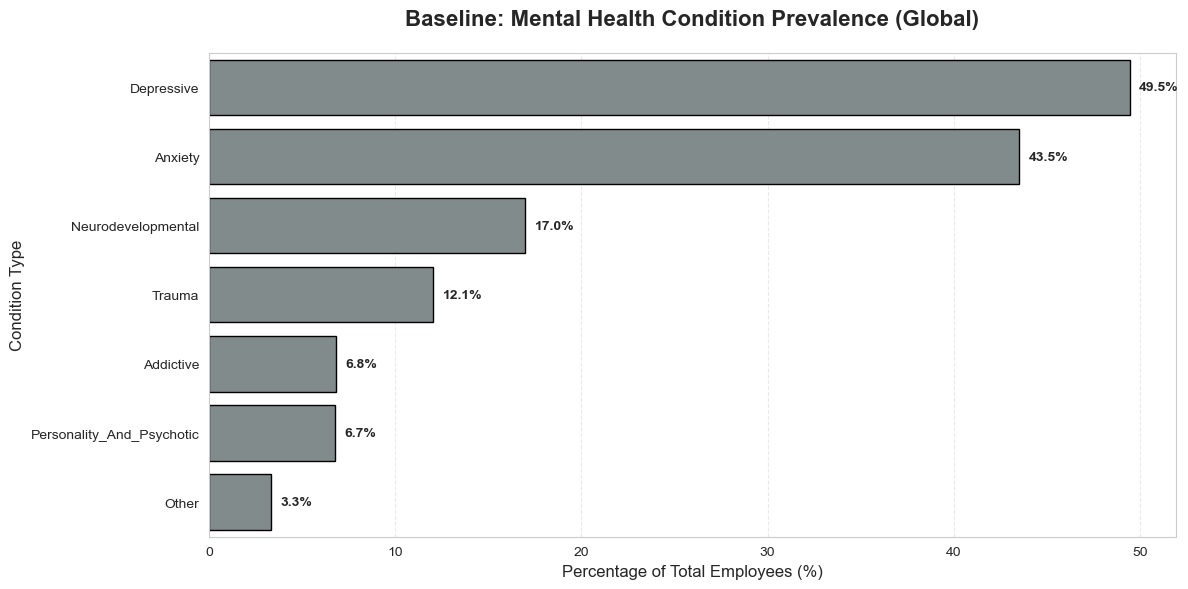

In [889]:
# --- 1. Global Condition Distribution (Baseline) ---

# Extracting condition columns (assumes they start with 'condition_')
condition_cols = [c for c in df_clean.columns if 'condition_' in c.lower()]

# Calculating the percentage of 'Yes' for each condition
global_conditions = (df_clean[condition_cols] == 'Yes').mean().sort_values(ascending=False) * 100
global_conditions.index = global_conditions.index.str.replace('condition_', '').str.title()

plt.figure(figsize=(12, 6))
sns.barplot(x=global_conditions.values, y=global_conditions.index, color='#7f8c8d', edgecolor='black')

# Styling
plt.title('Baseline: Mental Health Condition Prevalence (Global)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage of Total Employees (%)', fontsize=12)
plt.ylabel('Condition Type', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Adding value labels
for i, val in enumerate(global_conditions.values):
    plt.text(val + 0.5, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [890]:
#Numerical + categorical DF
df_mix = df_cat.copy()
cat_cols = df_mix.select_dtypes(include=['object']).columns
df_mix[cat_cols] = df_mix[cat_cols].astype('category')

In [891]:
#Full numerical encoded
df_num = df_cat.copy()
cat_cols = df_num.select_dtypes(include=['object']).columns

onehot = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
encoded = onehot.fit_transform(df_num[cat_cols])
encoded = pd.DataFrame(encoded, columns=onehot.get_feature_names_out(cat_cols), index=df_num.index)

df_num = pd.concat([df_num.drop(columns=cat_cols), encoded], axis=1)

In [892]:
df_mix.head()

company_size is_tech_company benefits_coverage know_options discussed_mh  \
0             2             Yes                No          N/A           No   
1             1             Yes                No          Yes          Yes   
2             1             Yes                No          N/A           No   
4             1              No               Yes          Yes           No   
5             5             Yes               Yes      Unknown           No   

  offer_resources anonymity_protected  leave_difficulty  \
0              No             Unknown                 0   
1             Yes                 Yes                 1   
2              No             Unknown                 2   
4              No                  No                 2   
5             Yes                 Yes                 1   

   neg_consequence_employer  neg_consequence_physical  discuss_coworkers  \
0                         0                         0                  1   
1                         0                         0                  1   
2                         1                         0                  1   
4                         2                         1                  1   
5                         2                         2                  1   

   discuss_supervisor mh_vs_ph obs_consequence_coworkers has_prev_employer  \
0                   2  Unknown                        No               Yes   
1                   2      Yes                        No               Yes   
2                   1  Unknown                        No               Yes   
4                   0       No                        No               Yes   
5                   2       No                       Yes               Yes   

   prev_benefits  prev_know_options  prev_discussed_mh  prev_resources  \
0              0                  0                  1               0   
1              2                  1                  0               1   
2              0                  0                  0               1   
4              1                  0                  1               0   
5              0                  2                  0               0   

   prev_anonymity  prev_neg_consequence  prev_neg_consequence_physical  \
0               1                     1                              0   
1               2                     0                              0   
2               1                     1                              1   
4               1                     1                              1   
5               1                     2                              1   

   prev_discuss_coworkers  prev_discuss_supervisor  prev_mh_vs_ph  \
0                       1                        1              1   
1                       0                        1              1   
2                       1                        1              1   
4                       0                        1              1   
5                       0                        0              0   

   prev_obs_consequence  interview_physical_reveal  interview_mh_reveal  \
0                     0                          1                    1   
1                     0                          1                    0   
2                     1                          2                    2   
4                     1                          1                    0   
5                     1                          2                    1   

   impact_on_career  coworker_stigma  share_with_friends_family  \
0                 1                0                          3   
1                 0                0                          3   
2                 1                1                          3   
4                 2                1                          3   
5                 2                1                          3   

   bad_response_observed  influence_reveal family_history  past_mh_disorder  \
0        

In [893]:
df_num.head()

company_size  leave_difficulty  neg_consequence_employer  \
0             2                 0                         0   
1             1                 1                         0   
2             1                 2                         1   
4             1                 2                         2   
5             5                 1                         2   

   neg_consequence_physical  discuss_coworkers  discuss_supervisor  \
0                         0                  1                   2   
1                         0                  1                   2   
2                         0                  1                   1   
4                         1                  1                   0   
5                         2                  1                   2   

   prev_benefits  prev_know_options  prev_discussed_mh  prev_resources  \
0              0                  0                  1               0   
1              2                  1                  0               1   
2              0                  0                  0               1   
4              1                  0                  1               0   
5              0                  2                  0               0   

   prev_anonymity  prev_neg_consequence  prev_neg_consequence_physical  \
0               1                     1                              0   
1               2                     0                              0   
2               1                     1                              1   
4               1                     1                              1   
5               1                     2                              1   

   prev_discuss_coworkers  prev_discuss_supervisor  prev_mh_vs_ph  \
0                       1                        1              1   
1                       0                        1              1   
2                       1                        1              1   
4                       0                        1              1   
5                       0                        0              0   

   prev_obs_consequence  interview_physical_reveal  interview_mh_reveal  \
0                     0                          1                    1   
1                     0                          1                    0   
2                     1                          2                    2   
4                     1                          1                    0   
5                     1                          2                    1   

   impact_on_career  coworker_stigma  share_with_friends_family  \
0                 1                0                          3   
1                 0                0                          3   
2                 1                1                          3   
4                 2                1                          3   
5                 2                1                          3   

   bad_response_observed  influence_reveal  past_mh_disorder  \
0                      0                -1                 2   
1                      0                -1                 2   
2                      1                 2                 1   
4                      2                 2                 2   
5                      2                 0                 0   

   curr_mh_disorder  work_interference_treated  work_interference_untreated  \
0                 0                         -1                           -1   
1                 2                          1                            2   
2                 0                         -1                           -1   
4                 2                          2                            2   
5                 2                         -1                            3   

        age  remote  is_tech_company_Yes  benefits_coverage_Unknown  \
0  0.368421       1                    1                          0   
1  0.192982       0                    1  

In [894]:
#Feature Selection
print(df_mix.shape)
print(df_num.shape)

(1112, 57)
(1112, 72)


In [895]:
#Variance Threshold
X = df_num.drop(columns=['curr_mh_disorder'])
y = df_num['curr_mh_disorder']

selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]
print(X_reduced.shape)

(1112, 71)


In [896]:
#Mutual Information
scores = mutual_info_classif(X_reduced, y, discrete_features='auto', random_state=42)
series = pd.Series(scores, index=X_reduced.columns)
print(series.sort_values(ascending=False).head(10))

work_interference_untreated         0.323859
past_mh_disorder                    0.313898
diagnosed_prof_Yes                  0.248927
work_interference_treated           0.244924
condition_depressive_Yes            0.214880
sought_treatment_Yes                0.199856
condition_anxiety_Yes               0.192748
condition_neurodevelopmental_Yes    0.076407
share_with_friends_family           0.067007
family_history_Yes                  0.062485
dtype: float64


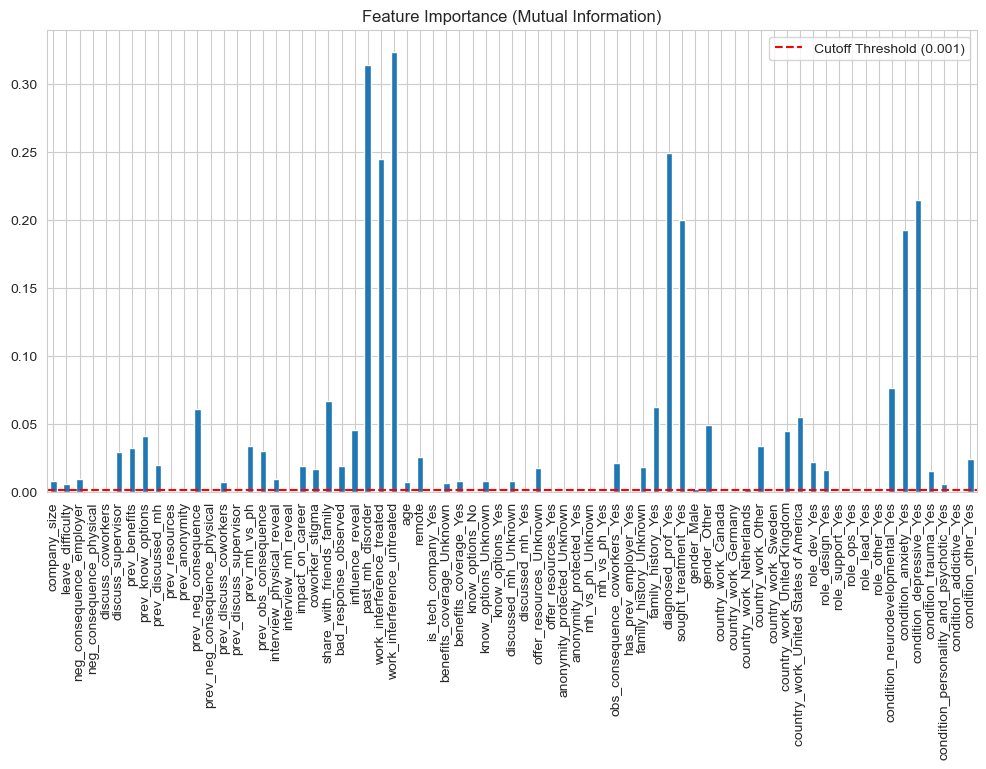

In [897]:
plt.figure(figsize=(12, 6))
series.plot(kind='bar')
plt.title("Feature Importance (Mutual Information)")
plt.axhline(y=0.001, color='r', linestyle='--', label='Cutoff Threshold (0.001)')
plt.legend()
plt.show()

In [898]:
threshold = 0.001
lower = series[series < threshold].index.tolist()

In [899]:
print(lower)

['neg_consequence_physical', 'discuss_coworkers', 'prev_resources', 'prev_anonymity', 'prev_neg_consequence_physical', 'prev_discuss_supervisor', 'interview_mh_reveal', 'is_tech_company_Yes', 'know_options_No', 'know_options_Yes', 'discussed_mh_Yes', 'offer_resources_Yes', 'anonymity_protected_Unknown', 'anonymity_protected_Yes', 'mh_vs_ph_Unknown', 'mh_vs_ph_Yes', 'has_prev_employer_Yes', 'country_work_Canada', 'country_work_Germany', 'country_work_Sweden', 'role_support_Yes', 'role_ops_Yes', 'role_lead_Yes', 'role_other_Yes', 'condition_addictive_Yes']


In [900]:
# Cramer's V Function
def cramers_v(x, y):
    matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    return np.sqrt((chi2 / n) / (min(matrix.shape) - 1))

In [901]:
#Collinearity check (> 0.80)
valid = [c for c in X_reduced.columns if c in df_mix.columns]
drop = set()

for i, j in combinations(valid, 2):
    v = cramers_v(df_mix[i], df_mix[j])
    if v > 0.80:
        score_1 = series.get(i, 0)
        score_2 = series.get(j, 0)

        lowest = min(score_1, score_2)
        if lowest == score_1:
            drop.add(i)
        else:
            drop.add(j)

In [902]:
df_mix = df_mix.drop(columns=drop)
df_num = df_num.drop(columns=drop)
print(df_mix.shape, df_num.shape)

(1112, 57) (1112, 72)


In [903]:
df_mix.isnull().sum().sum()

0

In [904]:
df_mix.to_csv('../data/processed/df_cat.csv', index=False, quoting=csv.QUOTE_ALL)
df_num.to_csv('../data/processed/df_num.csv', index=False, quoting=csv.QUOTE_ALL)

In [905]:
#FAMD
df = pd.read_csv('../data/processed/df_cat.csv', keep_default_na=False, na_values='')
cat_cols = df.select_dtypes(exclude=['number']).columns
df[cat_cols] = df[cat_cols].astype('category')

In [907]:
famd = prince.FAMD(n_components=2, n_iter=3, copy=True, check_input=True, random_state=42)

famd = famd.fit(df)

In [908]:
print(famd.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0            344.290         9.91%                      9.91%
1            203.094         5.85%                     15.76%


In [909]:
loadings = famd.column_coordinates_
print(loadings[0].abs().sort_values(ascending=False).head(10))
print(loadings[1].abs().sort_values(ascending=False).head(10))

variable
prev_know_options                0.986906
prev_obs_consequence             0.986802
prev_resources                   0.985944
prev_benefits                    0.985857
prev_neg_consequence             0.985774
prev_discussed_mh                0.985585
prev_mh_vs_ph                    0.985582
prev_anonymity                   0.985442
prev_neg_consequence_physical    0.985440
prev_discuss_supervisor          0.985438
Name: 0, dtype: float64
variable
work_interference_untreated    0.526433
curr_mh_disorder               0.486329
past_mh_disorder               0.479181
diagnosed_prof                 0.447228
work_interference_treated      0.435871
sought_treatment               0.421763
condition_depressive           0.350062
neg_consequence_employer       0.269798
condition_anxiety              0.258035
influence_reveal               0.240557
Name: 1, dtype: float64


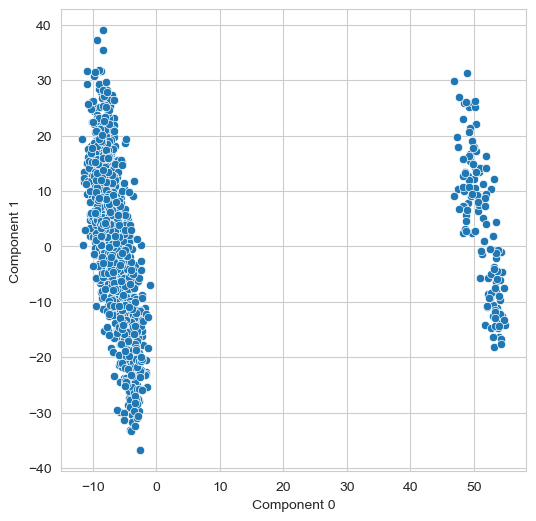

In [910]:
coords = famd.row_coordinates(df)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=coords, x=0, y=1)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

In [911]:
contributions = famd.column_contributions_
print(contributions.head())

# To see the top 5 drivers for Component 0:
print(contributions[0].sort_values(ascending=False).head(5))

component                     0         1
variable                                 
age                    0.000096  0.000008
anonymity_protected    0.000031  0.000099
bad_response_observed  0.000111  0.001153
benefits_coverage      0.000033  0.000185
company_size           0.000018  0.000110
variable
prev_know_options       0.002866
prev_obs_consequence    0.002866
prev_resources          0.002864
prev_benefits           0.002863
prev_neg_consequence    0.002863
Name: 0, dtype: float64


In [912]:
for col in df.select_dtypes(include='category').columns:
    crosstab = pd.crosstab(df[col], coords[0] > 0)
    print(col)
    print(crosstab)

is_tech_company
0                False  True 
is_tech_company              
No                 209     32
Yes                776     95
benefits_coverage
0                  False  True 
benefits_coverage              
No                   248     42
Unknown              272     36
Yes                  465     49
know_options
0             False  True 
know_options              
N/A             110     16
No              306     41
Unknown         300     43
Yes             269     27
discussed_mh
0             False  True 
discussed_mh              
No              699     96
Unknown          92      7
Yes             194     24
offer_resources
0                False  True 
offer_resources              
No                 449     69
Unknown            281     31
Yes                255     27
anonymity_protected
0                    False  True 
anonymity_protected              
No                      65     17
Unknown                643     81
Yes                    277     29
mh_vs_p

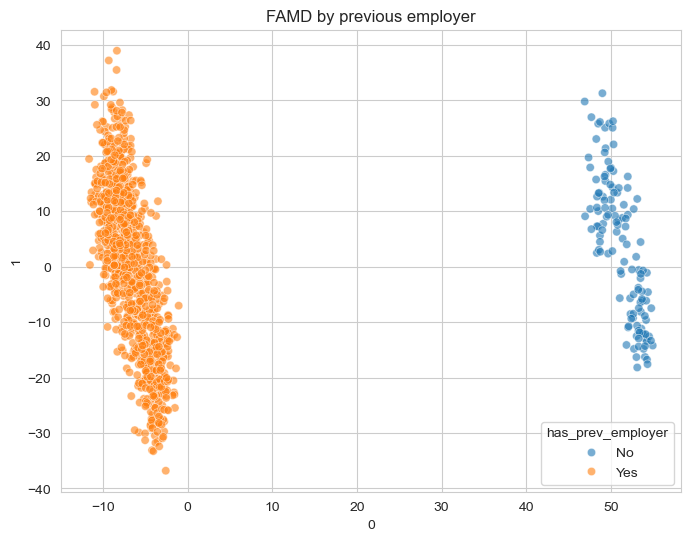

In [913]:
coords['has_prev_employer'] = df['has_prev_employer'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=coords, x=0, y=1, hue='has_prev_employer', alpha=0.6)
plt.title("FAMD by previous employer")
plt.show()

In [914]:
df_filter = df.drop(columns=['has_prev_employer'])
famd_filter = prince.FAMD(n_components=2).fit(df_filter)
famd_filter.plot(df_filter)

alt.LayerChart(...)

In [915]:
contributions_filter = famd_filter.column_contributions_

#Component 0 inertia
inertia_c0 = contributions_filter[0].sort_values(ascending=False).head(10)

#Component 1 inertia
inertia_c1 = contributions_filter[1].sort_values(ascending=False).head(10)

print(inertia_c0)
print(inertia_c1)

variable
prev_know_options                0.003153
prev_obs_consequence             0.003153
prev_resources                   0.003149
prev_neg_consequence             0.003148
prev_benefits                    0.003148
prev_mh_vs_ph                    0.003147
prev_discussed_mh                0.003147
prev_discuss_supervisor          0.003147
prev_neg_consequence_physical    0.003147
prev_anonymity                   0.003147
Name: 0, dtype: float64
variable
work_interference_untreated    0.002606
curr_mh_disorder               0.002408
past_mh_disorder               0.002364
diagnosed_prof                 0.002209
work_interference_treated      0.002155
sought_treatment               0.002080
condition_depressive           0.001733
neg_consequence_employer       0.001372
condition_anxiety              0.001279
influence_reveal               0.001195
Name: 1, dtype: float64


In [916]:
prev_cols = [col for col in df.columns if 'prev' in col]
df = df.drop(columns=prev_cols + ['has_prev_employer'], errors='ignore')

In [917]:
df.shape

(1112, 45)

In [918]:
famd = prince.FAMD(n_components=2, n_iter=5, random_state=42)
famd = famd.fit(df)

In [919]:
print(famd.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0            148.389         7.49%                      7.49%
1            109.204         5.51%                     13.00%


In [920]:
loadings = famd.column_coordinates_
print(loadings[0].abs().sort_values(ascending=False).head(10))
print(loadings[1].abs().sort_values(ascending=False).head(10))

variable
work_interference_untreated    0.679216
past_mh_disorder               0.643146
curr_mh_disorder               0.623086
diagnosed_prof                 0.594422
work_interference_treated      0.582340
sought_treatment               0.568757
condition_depressive           0.441432
condition_anxiety              0.324633
family_history                 0.287831
bad_response_observed          0.198003
Name: 0, dtype: float64
variable
discuss_supervisor           0.479315
neg_consequence_employer     0.455239
discuss_coworkers            0.418960
impact_on_career             0.362434
coworker_stigma              0.346578
leave_difficulty             0.315485
mh_vs_ph                     0.300453
share_with_friends_family    0.227881
neg_consequence_physical     0.216333
anonymity_protected          0.172836
Name: 1, dtype: float64


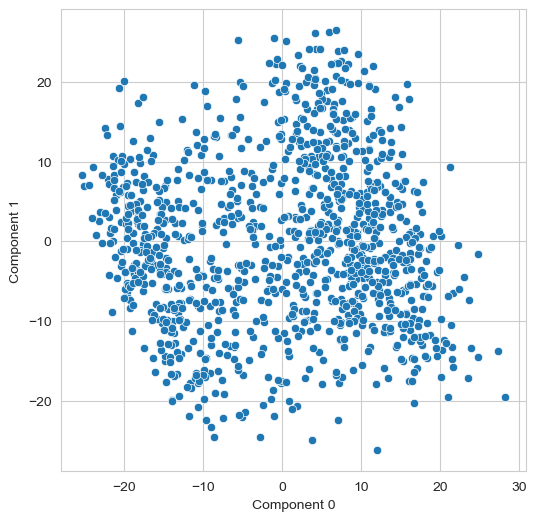

In [921]:
coords = famd.row_coordinates(df)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=coords, x=0, y=1)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

In [922]:
contributions = famd.column_contributions_
print(contributions[0].sort_values(ascending=False).head(5))
print(contributions[1].sort_values(ascending=False).head(5))

variable
work_interference_untreated    0.004577
past_mh_disorder               0.004334
curr_mh_disorder               0.004199
diagnosed_prof                 0.004006
work_interference_treated      0.003924
Name: 0, dtype: float64
variable
discuss_supervisor          0.004389
neg_consequence_employer    0.004169
discuss_coworkers           0.003836
impact_on_career            0.003319
coworker_stigma             0.003174
Name: 1, dtype: float64


In [923]:
#Gower Distance Matrix
df_gower = df.copy()
cat_cols = df_gower.select_dtypes(include=['category']).columns
df_gower[cat_cols] = df_gower[cat_cols].astype(object)

gower_dist = gower.gower_matrix(df_gower)

In [924]:
print(gower_dist.shape)
print(gower_dist.min())
print(gower_dist.max())

(1112, 1112)
0.0
0.77623785


In [925]:
#TSNE
tsne = TSNE(n_components=2, metric='precomputed', init = 'random', perplexity=40, random_state=42, n_jobs=-1)

result = tsne.fit_transform(gower_dist)
df_tsne = pd.DataFrame(result, columns=['dim_1', 'dim_2'])

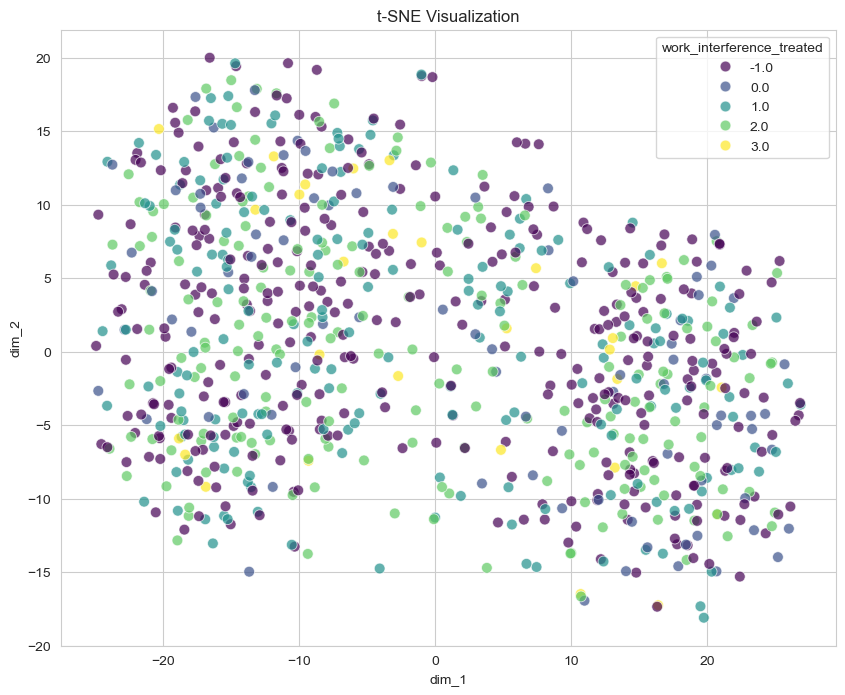

In [951]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='dim_1', y='dim_2', hue=df_cat['work_interference_treated'], palette='viridis', data=df_tsne, alpha=0.7, s=60)
plt.title('t-SNE Visualization')
plt.show()

In [927]:
#K-Prototypes
cats = [df.columns.get_loc(c) for c in df.select_dtypes(include='category').columns]

costs = []
k_range = range(2, 8)

print("Running Elbow Method...")
for k in k_range:
    try:
        kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, verbose=0, random_state=42, gamma=1.5)
        kproto.fit(df.values, categorical=cats)
        costs.append(kproto.cost_)
        print(f"  k={k}: Cost={kproto.cost_:.2f}")
    except Exception as e:
        print(f"  k={k}: Failed - {e}")

Running Elbow Method...
  k=2: Cost=26868.29
  k=3: Cost=25100.85
  k=4: Cost=24057.61
  k=5: Cost=23095.36
  k=6: Cost=22479.87
  k=7: Cost=21993.17


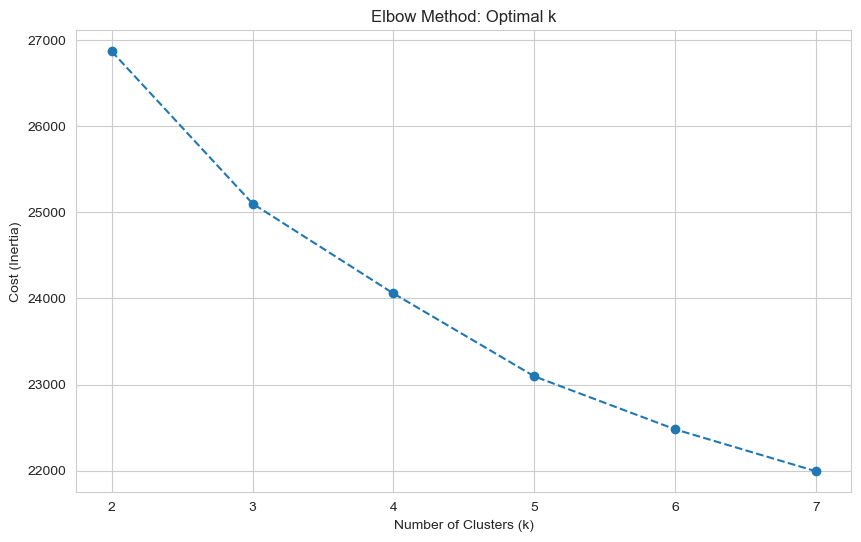

In [928]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, costs, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.grid(True)
plt.show()

In [929]:
#Hierarchical Clustering
gower_cond = squareform(gower_dist)
Z = linkage(gower_cond, method='complete')

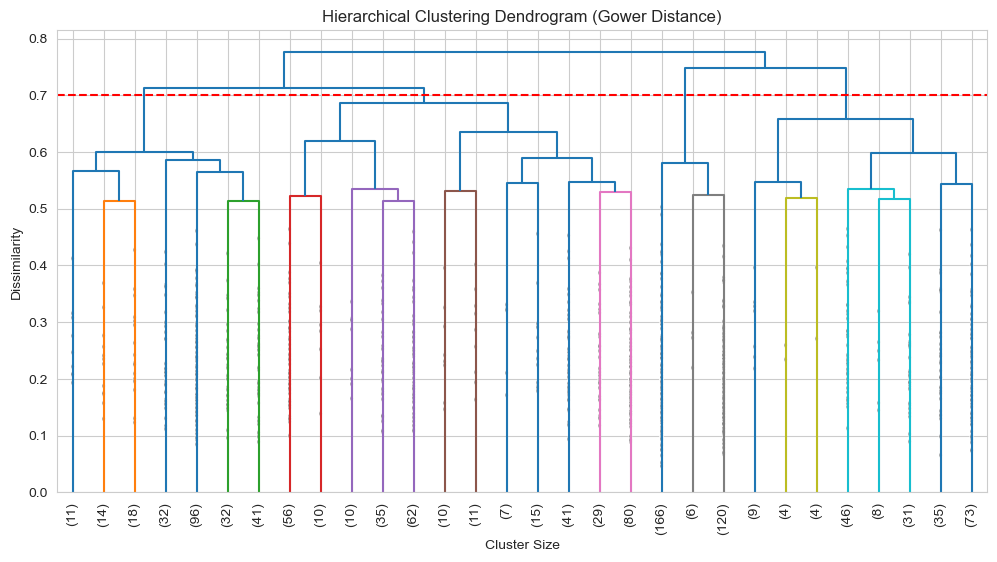

In [930]:
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Gower Distance)')
plt.xlabel('Cluster Size')
plt.ylabel('Dissimilarity')
plt.axhline(y=0.70, color='r', linestyle='--')
plt.show()

In [931]:
#Silhouette Score
def calculate_silhouette(df, k, cats, gower_dist):
    kp = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42, gamma=1.5)
    labels = kp.fit_predict(df, categorical=cats)
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    return score, labels


candidates = [2, 3, 4, 5]
print("Silhouette Scores:")
for k in candidates:
    score, _ = calculate_silhouette(df, k, cats, gower_dist)
    print(f'k={k}: {score:.4f}')

Silhouette Scores:
k=2: 0.1900
k=3: 0.1419
k=4: 0.0754
k=5: 0.0551


In [955]:
#Stability check
def stability(df, k, cats):
    kp1 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=42, gamma=1.5)
    labels1 = kp1.fit_predict(df, categorical=cats)
    
    kp2 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=101, gamma=1.5)
    labels2 = kp2.fit_predict(df, categorical=cats)
    
    index = adjusted_rand_score(labels1, labels2)
    
    print(f'Stability Index for k = {k}: {index:.4f}')

In [956]:
for k in candidates:
    stability(df, k, cats)

Stability Index for k = 2: 1.0000
Stability Index for k = 3: 0.8998
Stability Index for k = 4: 0.5107
Stability Index for k = 5: 0.5134


In [957]:
df.describe()

company_size  leave_difficulty  neg_consequence_employer  \
count   1112.000000       1112.000000               1112.000000   
mean       2.726619          1.741007                  0.804856   
std        1.534744          1.241863                  0.731602   
min        0.000000          0.000000                  0.000000   
25%        2.000000          1.000000                  0.000000   
50%        3.000000          2.000000                  1.000000   
75%        4.000000          3.000000                  1.000000   
max        5.000000          4.000000                  2.000000   

       neg_consequence_physical  discuss_coworkers  discuss_supervisor  \
count               1112.000000        1112.000000         1112.000000   
mean                   0.301259           0.896583            1.083633   
std                    0.529999           0.753693            0.812383   
min                    0.000000           0.000000            0.000000   
25%                    0.000000           0.000000            0.000000   
50%                    0.000000           1.000000            1.000000   
75%                    1.000000           1.000000            2.000000   
max                    2.000000           2.000000            2.000000   

       interview_physical_reveal  interview_mh_reveal  impact_on_career  \
count                1112.000000          1112.000000       1112.000000   
mean                    0.929856             0.449640          1.330036   
std                     0.758112             0.637262          0.691908   
min                     0.000000             0.000000          0.000000   
25%                     0.000000             0.000000          1.000000   
50%                     1.000000             0.000000          1.000000   
75%                     2.000000             1.000000          2.000000   
max                     2.000000             2.000000          2.000000   

       coworker_stigma  share_with_friends_family  bad_response_observed  \
count      1112.000000                1112.000000            1112.000000   
mean          0.988309                   2.328237               0.849820   
std           0.771247                   1.430412               0.831383   
min           0.000000                  -1.000000               0.000000   
25%           0.000000                   1.000000               0.000000   
50%           1.000000                   3.000000               1.000000   
75%           2.000000                   3.000000               2.000000   
max           2.000000                   4.000000               2.000000   

       influence_reveal  past_mh_disorder  curr_mh_disorder  \
count       1112.000000       1112.000000       1112.000000   
mean           0.125000          1.182554          1.006295   
std            1.136746          0.898013          0.882348   
min           -1.000000          0.000000          0.000000   
25%           -1.000000          0.000000          0.000000   
50%            0.000000          2.000000          1.000000   
75%            1.000000          2.000000          2.000000   
max            2.000000          2.000000          2.000000   

       work_interference_treated  work_interference_untreated          age  \
count                1112.000000                  1112.000000  1112.000000   
mean                    0.443345                     1.312050     0.269579   
std                     1.325656                     1.722075     0.136356   
min                    -1.000000                    -1.000000     0.000000   
25%                    -1.000000                    -1.000000     0.175439   
50%                     1.000000                     2.000000     0.245614   
75%                     2.000000                     3.000000     0.350877   
max                     3.000000                     3.000000     1.000000   

            remote  
count  1112.000000  
mean      0.918165  
std       0.677232  
min       0.000000  

In [934]:
#Final clustering
best_k = 3
best_gamma = 1.5

kp = KPrototypes(n_clusters=best_k, gamma=best_gamma, init='Cao', n_init=10, verbose=0, random_state=42)
cluster_labels = kp.fit_predict(df.values, categorical=cats)

df_final = df_mix.copy()
df_final['Cluster'] = cluster_labels

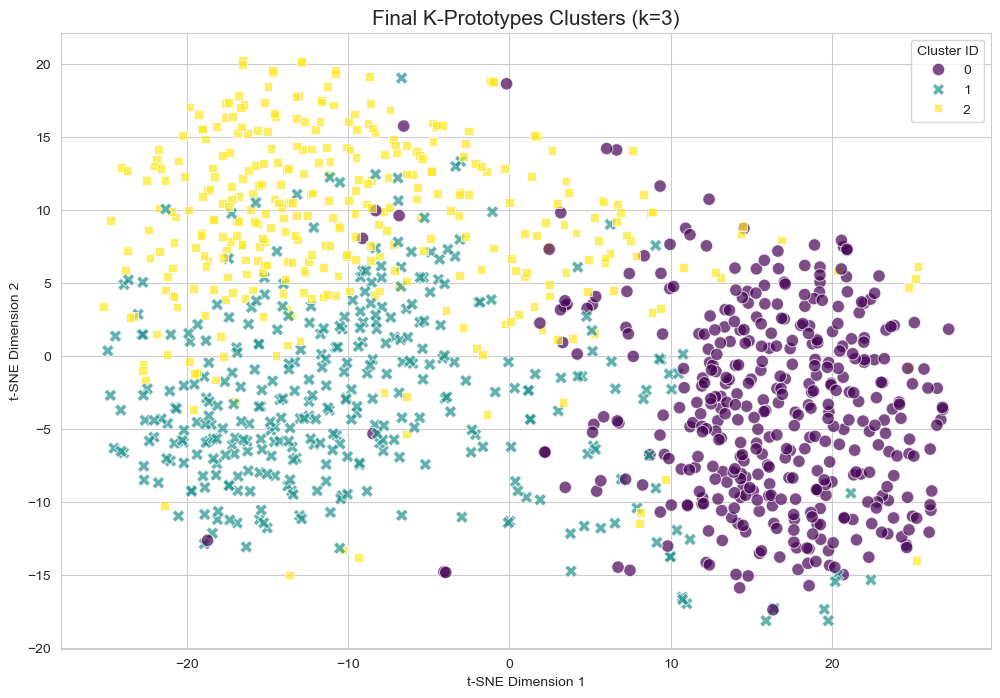

In [935]:
#Interim Visualization
tsne = TSNE(
    n_components=2, 
    metric='precomputed',
    init='random', 
    perplexity=40, 
    random_state=42, 
    n_jobs=-1
)

result = tsne.fit_transform(gower_dist)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=result[:, 0], 
    y=result[:, 1],
    hue=cluster_labels,
    palette='viridis', 
    style=cluster_labels,
    s=80, 
    alpha=0.7
)

plt.title(f'Final K-Prototypes Clusters (k={best_k})', fontsize=15)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster ID')
plt.show()


In [936]:
print(df_final['Cluster'].value_counts().sort_index())

Cluster
0    400
1    357
2    355
Name: count, dtype: int64


In [937]:
df_final.to_csv('../data/processed/df_clustered.csv', index=False, quoting=csv.QUOTE_ALL)

In [938]:
#Cluster Profiling
def profiles(df, cluster_col='Cluster'):
    cols = df.select_dtypes(include=['object', 'category']).columns
    cols = [c for c in cols if c not in ['Unnamed: 0']]
    
    nums = df.select_dtypes(include=['number']).columns
    nums = [c for c in nums if c not in [cluster_col, 'age']]
    
    modes = df.groupby(cluster_col)[cols].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    mean = df.groupby(cluster_col)['age'].mean().round(2) * 100
    mean = mean.astype(int)
    means = df.groupby(cluster_col)[nums].mean().round().astype(int)
    
    return pd.concat([mean, modes, means], axis=1).sort_index().T

In [939]:
cluster_stats = profiles(df_final)

In [940]:
display(cluster_stats)

Cluster                                                     0  \
age                                                        26   
is_tech_company                                           Yes   
benefits_coverage                                     Unknown   
know_options                                               No   
discussed_mh                                               No   
offer_resources                                            No   
anonymity_protected                                   Unknown   
mh_vs_ph                                              Unknown   
obs_consequence_coworkers                                  No   
has_prev_employer                                         Yes   
family_history                                             No   
diagnosed_prof                                             No   
sought_treatment                                           No   
gender                                                   Male   
country_work                         United States of America   
role_dev                                                  Yes   
role_design                                                No   
role_support                                               No   
role_ops                                                   No   
role_lead                                                  No   
role_other                                                 No   
condition_neurodevelopmental                               No   
condition_anxiety                                          No   
condition_depressive                                       No   
condition_trauma                                           No   
condition_personality_and_psychotic                        No   
condition_addictive                                        No   
condition_other                                            No   
company_size                                                3   
leave_difficulty                                            1   
neg_consequence_employer                                    1   
neg_consequence_physical                                    0   
discuss_coworkers                                           1   
discuss_supervisor                                          1   
prev_benefits                                               1   
prev_know_options                                           0   
prev_discussed_mh                                           0   
prev_resources                                              0   
prev_anonymity                                              1   
prev_neg_consequence                                        1   
prev_neg_consequence_physical                               0   
prev_discuss_coworkers                                      1   
prev_discuss_supervisor                                     1   
prev_mh_vs_ph                                               1   
prev_obs_consequence                                        0   
interview_physical_reveal                                   1   
interview_mh_reveal                                         1   
impact_on_career                                            1   
coworker_stigma                                             1   
share_with_friends_family                                   2   
bad_response_observed                                       1   
influence_reveal                                            0   
past_mh_disorder                                            0   
curr_mh_disorder                                            0   
work_interference_treated                                  -1   
work_interference_untreated                                -1   
remote                                                      1   

Cluster                                                     1  \
age                                                        27   
is_tech_company                                           Yes   
benefits_coverage                 

In [941]:
def features(df, cluster_col='Cluster', n=5, min_pct=25):
    feats = {}
    # Separate features from the cluster label
    features_only = df.drop(columns=[cluster_col])
    global_props = features_only.apply(lambda x: x.value_counts(normalize=True))
    
    for cluster in sorted(df[cluster_col].unique()):
        subset = df[df[cluster_col] == cluster]
        cluster_props = subset.drop(columns=[cluster_col]).apply(lambda x: x.value_counts(normalize=True))
        
        # Calculate the absolute difference in percentage points
        diff = cluster_props - global_props
        
        # Transform to long format for easier filtering
        diff_df = diff.unstack().reset_index()
        diff_df.columns = ['Feature', 'Value', 'Gap']
        
        # Add the absolute prevalence within the cluster for filtering
        cluster_prev = cluster_props.unstack().reset_index()
        cluster_prev.columns = ['Feature', 'Value', 'Prevalence']
        
        final_diff = diff_df.merge(cluster_prev, on=['Feature', 'Value'])
        
        # Logic Fix: Only include traits that apply to >25% of the cluster
        # and are significantly more common than average
        filtered = final_diff[(final_diff['Prevalence'] >= (min_pct/100)) & (final_diff['Gap'] > 0)]
        
        feats[cluster] = filtered.sort_values('Gap', ascending=False).head(n)
        
    return feats

In [942]:
characteristics = features(df_final)

In [943]:
for cluster, traits in characteristics.items():
    print(f"\n--- Persona Profile: Cluster {cluster} ---")
    for _, row in traits.iterrows():
        print(f"• {row['Feature'].replace('_', ' ').title()} [{row['Value']}]: "
              f"+{row['Gap']:.1%} difference ({row['Prevalence']:.1%} of group)")


--- Persona Profile: Cluster 0 ---
• Work Interference Untreated [-1]: +57.2% difference (90.5% of group)
• Work Interference Treated [-1]: +54.4% difference (93.8% of group)
• Diagnosed Prof [No]: +46.5% difference (96.8% of group)
• Curr Mh Disorder [0]: +45.9% difference (84.5% of group)
• Sought Treatment [No]: +44.9% difference (87.5% of group)

--- Persona Profile: Cluster 1 ---
• Diagnosed Prof [Yes]: +26.2% difference (75.9% of group)
• Neg Consequence Employer [0]: +26.0% difference (64.4% of group)
• Sought Treatment [Yes]: +25.3% difference (82.6% of group)
• Discuss Supervisor [2]: +25.2% difference (62.7% of group)
• Past Mh Disorder [2]: +25.1% difference (76.2% of group)

--- Persona Profile: Cluster 2 ---
• Impact On Career [2]: +27.1% difference (73.0% of group)
• Diagnosed Prof [Yes]: +26.0% difference (75.8% of group)
• Past Mh Disorder [2]: +25.8% difference (76.9% of group)
• Condition Depressive [Yes]: +25.8% difference (75.2% of group)
• Coworker Stigma [2]: +25

<Figure size 1000x600 with 0 Axes>

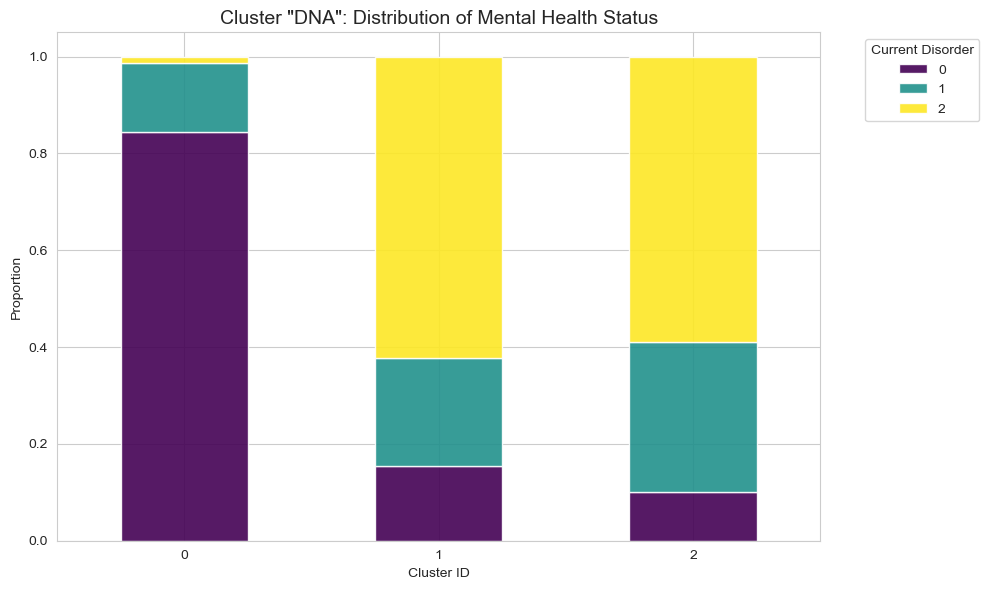

In [944]:
plt.figure(figsize=(10, 6))
cross = pd.crosstab(df_final['Cluster'], df_final['curr_mh_disorder'], normalize='index')

# Plot
ax = cross.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6), alpha=0.9)
plt.title('Cluster "DNA": Distribution of Mental Health Status', fontsize=14)
plt.xlabel('Cluster ID')
plt.ylabel('Proportion')
plt.legend(title='Current Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [945]:
def perform_statistical_audit(df, cluster_col='Cluster', target_cols=None):
    if target_cols is None:
        # Using specific columns from your index
        target_cols = ['neg_consequence_employer', 'bad_response_observed', 
                       'sought_treatment', 'work_interference_untreated', 'discuss_supervisor']
    
    results = []
    
    for col in target_cols:
        # 1. Chi-Square Test (Valid for all categorical types)
        contingency_table = pd.crosstab(df[cluster_col], df[col])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        
        # 2. Odds Ratio: Comparing "High-Risk" behavior between C2 and C0
        # We determine the "High-Risk" value dynamically
        if df[col].dtype.kind in 'iufb': # If numeric/encoded ordinal
            target_val = df[col].max()
        else:
            # If string/nominal, take the most frequent value in the 'at-risk' Cluster 2
            target_val = df[df[cluster_col] == 2][col].mode()[0]
        
        # Binary split for Odds Ratio
        c2_target = len(df[(df[cluster_col] == 2) & (df[col] == target_val)])
        c2_other = len(df[(df[cluster_col] == 2) & (df[col] != target_val)])
        c0_target = len(df[(df[cluster_col] == 0) & (df[col] == target_val)])
        c0_other = len(df[(df[cluster_col] == 0) & (df[col] != target_val)])
        
        # Odds Ratio with Haldane-Anscombe correction to prevent division by zero
        num = (c2_target + 0.5) / (c2_other + 0.5)
        den = (c0_target + 0.5) / (c0_other + 0.5)
        odds_ratio = num / den
        
        results.append({
            'Feature': col,
            'Target Value': target_val,
            'p-value': f"{p:.4e}",
            'Significant': p < 0.05,
            'Odds Ratio (C2 vs C0)': round(odds_ratio, 2)
        })
    
    return pd.DataFrame(results)

# Execute updated audit
stats_audit = perform_statistical_audit(df_final)
display(stats_audit)

Feature Target Value      p-value  Significant  \
0     neg_consequence_employer            2   8.4888e-74         True   
1        bad_response_observed            2   3.2252e-46         True   
2             sought_treatment          Yes  2.0088e-112         True   
3  work_interference_untreated            3  6.5455e-203         True   
4           discuss_supervisor            2   1.0918e-53         True   

   Odds Ratio (C2 vs C0)  
0                   5.58  
1                   5.43  
2                  32.59  
3                 230.61  
4                   0.22

In [946]:
from sklearn.metrics import silhouette_samples

# Calculate individual scores
sample_silhouette_values = silhouette_samples(gower_dist, df_final['Cluster'], metric='precomputed')
df_final['silhouette_score'] = sample_silhouette_values

# Group by cluster to see which persona is mathematically strongest
cluster_strength = df_final.groupby('Cluster')['silhouette_score'].mean().reset_index()
cluster_strength.columns = ['Cluster', 'Mean Silhouette (Stability)']
display(cluster_strength)

Cluster  Mean Silhouette (Stability)
0        0                     0.242656
1        1                     0.078920
2        2                     0.086496

In [947]:
cluster_stats.to_csv('../data/processed/cluster_profiles.csv')

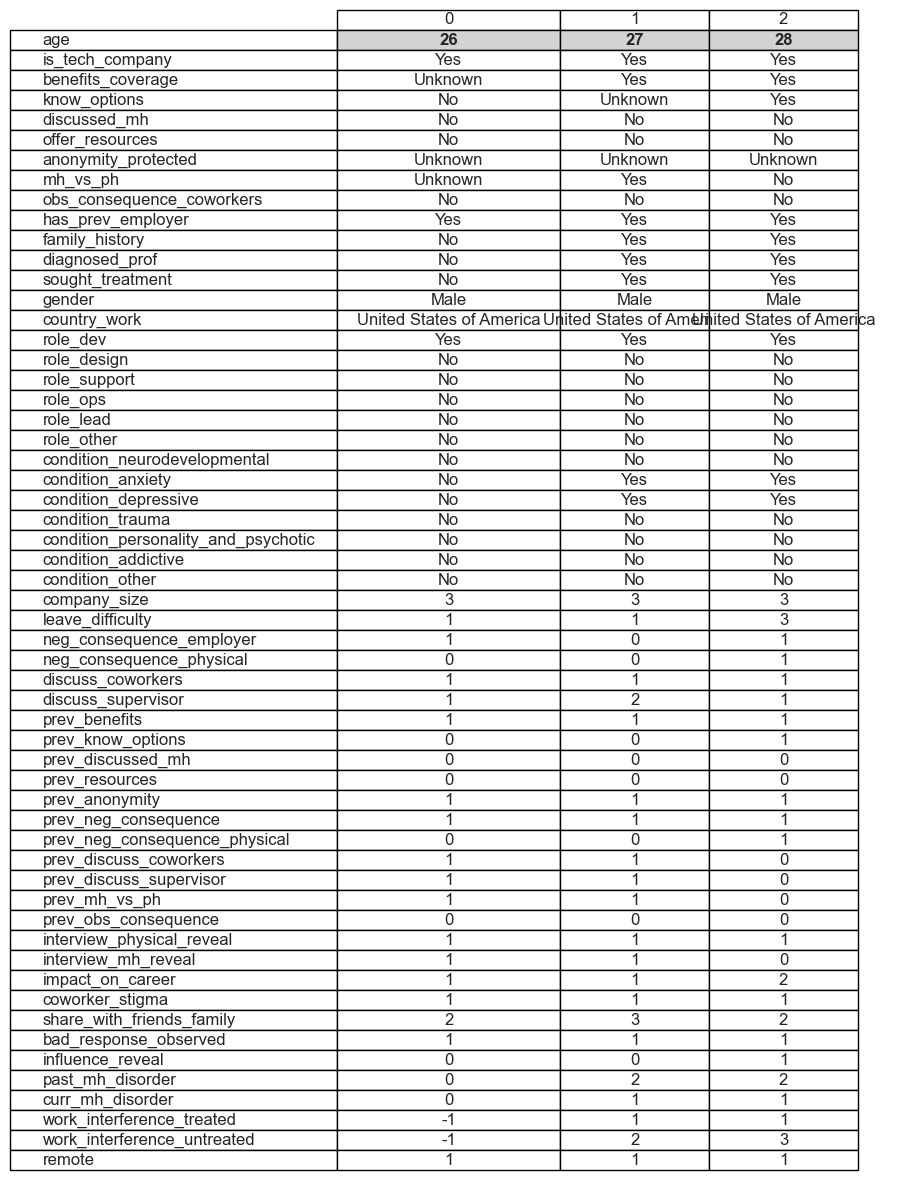

In [958]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

# Create table
table = ax.table(cellText=cluster_stats, 
                 loc='center', 
                 cellLoc='center', 
                 colWidths=[0.3, 0.2, 0.2]) 


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2) 

for i, cell in enumerate(table.get_celld().values()):
    if i < 3:  # First row (headers)
        cell.set_facecolor('#d3d3d3')  # Light gray
        cell.set_text_props(weight='bold')


plt.savefig('../figures/profile_table.png', bbox_inches='tight', dpi=300)
plt.show()